このPython コードは、PyMC を使ってMCMCサンプリングを行います。
* 2025年8月時点では、Google Colaboratory環境では PyMC がそのまま使えますので、実行可能です。
* ローカルな計算機環境では、PyMC パッケージが含まれていないのが一般的です。
    * 例えば、Anaconda などの Distribution では、以下の例の様に、PyMC環境を用意する必要があります。
        ```
        conda create -c conda-forge -n pymc_env pymc
        conda activate pymc_env
        conda install conda-forge::ipywidgets
        conda install scikit-learn
        ```
        * これで VS codeの実行時のPython環境に、```pymc_env```を選択します。

In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2PyMC-07ThreePeaks-01NUTS/'
FileBaseName = '2PyMC-07ThreePeaks-01NUTS'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
# https://docs.pymc.io/
import pymc as pm
import time
print('pymc       Ver.', pm.__version__)
#
############################################
import pickle
#
############################################
import pandas as pd
#
############################################
from scipy import stats
import scipy.optimize as opt
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.10.0
numpy      Ver. 1.26.4


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc       Ver. 5.16.1
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/


---
最確値を書式化して文字列として返す関数
```
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
```
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。
*   parens=False: True では$\pm$表記ではなく、 値 (精度)となる。

In [4]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False, parens=False  ):
  #
  # 平均値の冪数
  # order_mean = np.floor( np.log10(v_mean) )
  order_mean = np.floor( np.log10(np.abs(v_mean)) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    if parens:
      # 共通した冪数で指数をくくって、係数は少数第1位
      if latex:
        out_str = r'(%+.1f [%.1f])$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
      else:
        out_str = '(%+.1f [%.1f])x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    else:
      # 共通した冪数で指数をくくって、係数は少数第1位
      if latex:
        out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
      else:
        out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    fmt_std1 = r'%%+.%df' % -order_std
    fmt_std2 = r'%%.%df'  % -order_std
    #
    if parens:
      if latex:
        fmt_str = fmt_std1 + r' (' + fmt_std2 + ') ' + s_unit
      else:
        fmt_str = fmt_std1 + ' (' + fmt_std2 + ') ' + s_unit
    else:
      if latex:
        fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
      else:
        fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

---
Yes/No

In [5]:
def YESorNO( prompt ):
  print( prompt )
  while True:
    yes_or_no = input(">> 'YES' or 'NO' [Y/N]: ").upper()
    if yes_or_no in ['Y', 'YES']:
      return True
    elif yes_or_no in ['N', 'NO']:
      return False

---
スペクトル分解の例
* 3つのピークを含むスペクトルデータのPyMCによるサンプリング。

* 参考文献のスペクトルデータを利用する。
    * Ref; [K. Nagata, S. Sugita, M. Okada; Bayesian spectral deconvolution with the exchange Monte Carlo method; Neural Networks **28**, 82 (2012). ](https://doi.org/10.1016/j.neunet.2011.12.001)

1. スペクトル形状関数
$$
\phi_k(x;a_k,\mu_k, b_k)=a_k \exp\left[-\frac{b_k}{2}(x-\mu_k)^2\right]
$$
* $a_k$: ピーク強度
* $b_k$: ピーク幅に関わる係数 (幅の逆2乗に比例)
* $\mu_k$: ピークの中心

2. 成分
$$
\begin{array}{|c||c|c|c|}
\hline
成分 & a_k & \mu_k & b_k \\
\hline\hline
k=1 & 0.587 & 1.210 & 95.689 \\
\hline
k=2 & 1.522 & 1.455 & 146.837 \\
\hline
k=3 & 1.183 & 1.703 & 164.469 \\
\hline
\end{array}
$$

3. 3つのピーク成分をもつスペクトル関数
$$
g(x;\boldsymbol{\theta})
=
\sum_{k=1}^{3}
\phi_k(x;a_k,\mu_k, b_k)
=
\sum_{k=1}^{3}
a_k \exp\left[-\frac{b_k}{2}(x-\mu_k)^2\right]
$$
$$
\boldsymbol{\theta}=\{a_1,\mu_1,b_1,a_2,\mu_2,b_2,a_3,\mu_3,b_3\}
$$

4. 人工データと解析データの準備
* $x$軸データ: $x=0.0\sim3.0$, データ点数: $M=301$
* 人工(真値)データ
$$
y_{\rm true}=\sum_{k=1}^{3}
a_k \exp\left[-\frac{b_k}{2}(x-\mu_k)^2\right]
$$

* 解析データ
$$
y=y_{\rm true}+{\cal N}(0,\sigma_\textrm{noise}),
\;\;\;
\sigma_\textrm{noise}=0.04
$$

In [6]:
############################################
# 1. スペクトル形状関数
def Gauss1(x, a, mu, b):
    return a * np.exp( -b*(x-mu)*(x-mu)/2 )
#
############################################
# 2. 成分
a1_true  = 0.587
mu1_true = 1.210
b1_true  = 95.689
#
a2_true  = 1.522
mu2_true = 1.455
b2_true  = 146.837
#
a3_true  = 1.183
mu3_true = 1.703
b3_true  = 164.469
#
############################################
# 3. 3つのピーク成分をもつスペクトル関数
def Gauss3(x, a1, mu1, b1, a2, mu2, b2, a3, mu3, b3 ):
    y = Gauss1(x, a1, mu1, b1) + Gauss1(x, a2, mu2, b2) + Gauss1(x, a3, mu3, b3)
    return y
#
############################################
# 4. 人工データと解析データの準備
M = 301
#
X = np.linspace(0, 3.0, num=M, endpoint=True )
#
############################################
Y1_true = Gauss1(X, a1_true,mu1_true,b1_true )
Y2_true = Gauss1(X, a2_true,mu2_true,b2_true )
Y3_true = Gauss1(X, a3_true,mu3_true,b3_true )
Y_true  = Gauss3(X, a1_true,mu1_true,b1_true, a2_true,mu2_true,b2_true, a3_true,mu3_true,b3_true )
#
# sigma_noise = 0.04
sigma_noise = 0.1
#
# np.random.seed(seed=1)
#
Y_noise = np.random.normal( loc=0, scale=1.0, size=M )
Y_noise_mean = np.mean(Y_noise)
Y_noise_std  = np.std(Y_noise)
#
Y_noise = (Y_noise - Y_noise_mean) / Y_noise_std * sigma_noise
#
print( 'Y_noise_mean = %+.6f' % np.mean(Y_noise) )
print( 'Y_noise_std  = %+.6f' % np.std(Y_noise) )
#
Y = Y_true + Y_noise


Y_noise_mean = +0.000000
Y_noise_std  = +0.100000


---
スペクトルデータのグラフを描く関数

In [7]:
######################################
# Yset = [ ydata, ystyle, ylabel, ycolor ]
# ystyle = 1: scatter, 2: plot(solid), 3: plot(dashed), 4: plot(dotted)
######################################
def grf_Gauss( x, Ysets, title ):
    #
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    fig.subplots_adjust( left=0.15, right=0.98, top=0.93,  bottom=0.1 )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    #
    for Yset in Ysets:
      #
      ydata  = Yset[0]
      ystyle = Yset[1]
      ylabel = Yset[2]
      ycolor = Yset[3]
      #
      if ystyle==1:
        ax1.scatter( x, ydata, color=ycolor, s=10.0, label=ylabel )
      elif ystyle==2:
        ax1.plot( x, ydata, color=ycolor, linewidth=2.0, label=ylabel )
      elif ystyle==3:
        ax1.plot( x, ydata, color=ycolor, linewidth=2.0, label=ylabel, linestyle='dashed' )
      elif ystyle==4:
        ax1.fill_between( x, ydata, color=ycolor, linewidth=0.0, label=ylabel, alpha=0.5 )
    #
    plt.title( title )
    plt.legend()
    #
    plt.show()
    #
    return fig

真値データと解析データのスペクトルの描画と出力

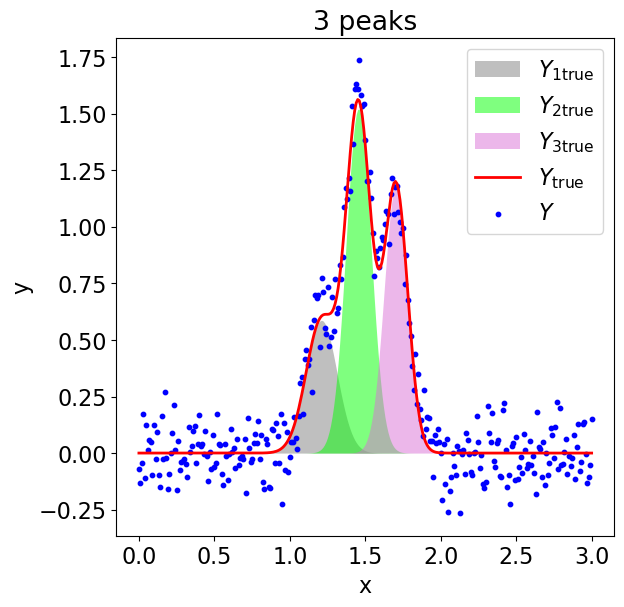

In [8]:
############################################
Ysets = [
    [ Y1_true, 4, r'$Y_{\rm 1true}$', 'gray'   ],
    [ Y2_true, 4, r'$Y_{\rm 2true}$', 'lime'   ],
    [ Y3_true, 4, r'$Y_{\rm 3true}$', 'orchid' ],
    [ Y_true,  2, r'$Y_{\rm true}$',  'red'    ],
    [ Y,       1, r'$Y$',             'blue'   ]
]
############################################
fig = grf_Gauss( X, Ysets, '3 peaks')
#
pdfName = FilePath + FileBaseName + "-data.pdf"
fig.savefig( pdfName )
#print( pdfName )

---
事前確率に用いる確率分布
1. 正規分布
$$
{\rm PNormal}(x;\mu,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}
\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right],
\;\;\;
x\in[-\infty,\infty]
$$

2. 一様分布
$$
{\rm PUniform}(x;lower,upper)=
\left\{
  \begin{array}{cc}
    \displaystyle
    \frac{1}{upper - lower},
    &
    x\in[lower,upper]
    \\
    0,
    &
    x\not\in[lower,upper]
  \end{array}
\right.
$$

3. ガンマ分布
$$
{\rm PGamma}(x;\alpha,\beta)=
\frac{\beta^\alpha{}x^{\alpha-1}}{\Gamma(\alpha)}\exp(-\beta{}x),
\;\;\;
x\in[0,\infty]
$$

In [9]:
############################################
from math import gamma as gamma_func
############################################
sqrt2pi = np.sqrt( 2 * np.pi )
############################################
# ##1. 正規分布
def PNormal(x, mu, sigma):
  return np.exp( - (x - mu)**2/(2 * sigma**2) ) / (sigma * sqrt2pi )
############################################
# ##2. 一様分布
def PUniform(x, lower, upper):
  # res = 1.0 / (upper-lower)
  # res[ (x<lower) ] = 0
  # res[ (x>upper) ] = 0
  #return res
  return (1-np.maximum( np.sign( (x-lower)*(x-upper) ), 0 ))/(upper-lower)
############################################
# ##3. ガンマ分布
def PGamma(x, alpha, beta):
    res = beta**alpha * x**(alpha-1) * np.exp(-beta*x)/ gamma_func(alpha)
    res[(x<0)] = 0
    return res

---
1.事前確率の設定
参考文献にならって、3つのスペクトル成分で、同じ事前確率を用いる。
* 参考文献; [K. Nagata, S. Sugita, M. Okada; Bayesian spectral deconvolution with the exchange Monte Carlo method; Neural Networks **28**, 82 (2012). ](https://doi.org/10.1016/j.neunet.2011.12.001)

  1. $\mu_{1}, \mu_{2}, \mu_{3}$; (ピークの中心)の事前確率$P(\mu)$
  $$
  P(\mu)={\cal N}(\mu=1.5, \sigma=1.0/\sqrt{10});\;\;\;(正規分布)
  $$

  2. $a_{1}, a_{2}, a_{3}$; (ピーク強度)の事前確率$P(a)$
  $$
  P(a)={\cal G}(\alpha=5.0, \beta=5.0)\;\;\;(ガンマ分布)
  $$

  3. $b_{1}, b_{2}, b_{3}$; ピーク幅に関わる係数 (幅の逆2乗に比例)の事前確率$P(b)$
  $$
  P(b)={\cal G}(\alpha=5.0, \beta=0.04)\;\;\;(ガンマ分布)
  $$

  4. RMSDの事前確率: データ全体の標準偏差 $\sigma_{Y}$ の2倍を上限とする
  $$
  P({\rm RMSD})={\cal U}(lower=0, upper=2\sigma_{Y})
  $$

2. 解析データの指定とモデリング
$$ y = {\cal N}(\mu,\sigma);\;\;\;\;\mu=g(x;\boldsymbol{\theta}), \;\;\;\;\sigma=P({\rm RMSD})$$

In [10]:
############################################
# 事前確率の描画関数とそのパラメータ
#
# 1. P(mu)
prior_mu_func = PNormal
prior_mu_mu   = 1.5
# prior_mu_sd   = 1.0 / np.sqrt(5.0)
prior_mu_sd   = 1.0 / np.sqrt(10.0)
#
# 2. P(a)
prior_a_func  = PGamma
prior_a_alpha = 5.0
prior_a_beta  = 5.0
#
# 3. P(b)
prior_b_func  = PGamma
prior_b_alpha = 5.0
prior_b_beta  = 0.04
#
# P(RMSD)
sigma_Y = np.std( Y )
print( 'sigma_Y = %+.6f' % sigma_Y )
prior_rmsd_func  = PUniform
prior_rmsd_lower = 0.0
prior_rmsd_upper = 2.0 * sigma_Y

sigma_Y = +0.436758


確率分布を描く関数

In [11]:
############################################
def grf_Prob( ProbSets, x_label, title, xticks_rotate=False):
    #
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    #
    figadj_bottom = 0.1
    #
    if xticks_rotate:
      figadj_bottom = 0.25
    #
    fig.subplots_adjust( \
            left=0.25, right=0.98,
            top=0.93,  bottom=figadj_bottom )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel( x_label )
    #
    if xticks_rotate:
      plt.xticks(rotation=90)
    #
    ax1.set_ylabel('Probability distribution')
    #
    for ProbSet in ProbSets:
      #
      plot_type  = ProbSet[0]
      plot_x     = ProbSet[1]
      plot_y     = ProbSet[2]
      plot_label = ProbSet[3]
      plot_color = ProbSet[4]
      #
      # plot_type == 0; plot
      if plot_type == 0:
        ax1.plot(plot_x, plot_y, color=plot_color, linewidth=2.0, label=plot_label )
      #
    #
    (x_left, x_right) = ax1.set_xlim()
    (y_bot, y_top) = ax1.set_ylim()
    (y_bot, y_top) = ax1.set_ylim(0, y_top*1.2)
    #
    for ProbSet in ProbSets:
      #
      plot_type  = ProbSet[0]
      plot_x     = ProbSet[1]
      plot_y     = ProbSet[2]
      plot_label = ProbSet[3]
      plot_color = ProbSet[4]
      #
      # plot_type == 1; vline
      if plot_type == 1:
        ax1.vlines(plot_x, y_bot, y_top, label=plot_label, color=plot_color, linestyles='dashed', linewidth=1.0)
    #
    plt.title( title )
    plt.legend()
    #
    plt.show()
    #
    return fig

$\mu_{1}$, $\mu_{2}$, $\mu_{3}$の事前確率

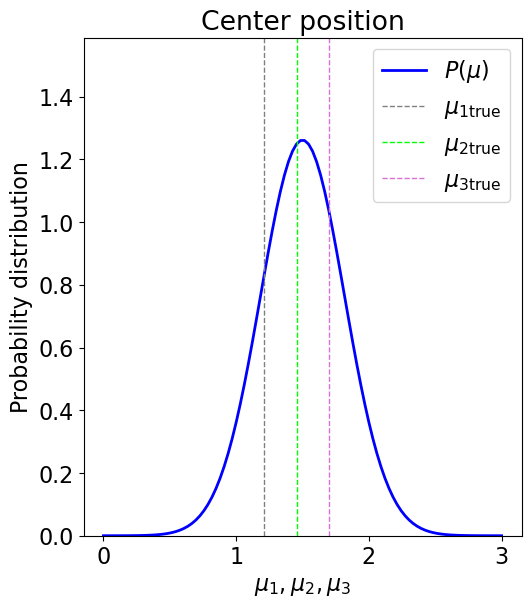

In [12]:
############################################
# 事前確率を描く横軸のポイント数
prob_points = 100
#
# mu1_true = 1.210
# mu2_true = 1.455
# mu3_true = 1.703
#
mu_x = np.linspace(0, 3.0, num=prob_points, endpoint=True )
mu_y = prior_mu_func(mu_x, prior_mu_mu, prior_mu_sd)
#
############################################
ProbSets = [
    [ 0, mu_x,     mu_y,  r'$P(\mu)$',        'blue'   ],
    [ 1, mu1_true, None, r'$\mu_{\rm 1true}$','gray'   ],
    [ 1, mu2_true, None, r'$\mu_{\rm 2true}$','lime'   ],
    [ 1, mu3_true, None, r'$\mu_{\rm 3true}$','orchid' ]
]
#
fig = grf_Prob( ProbSets, r'$\mu_{1}, \mu_{2}, \mu_{3}$', 'Center position')
pdfName = FilePath + FileBaseName + '-Prior-mu.pdf'
fig.savefig( pdfName )

$a_{1}$, $a_{2}$, $a_{3}$の事前確率

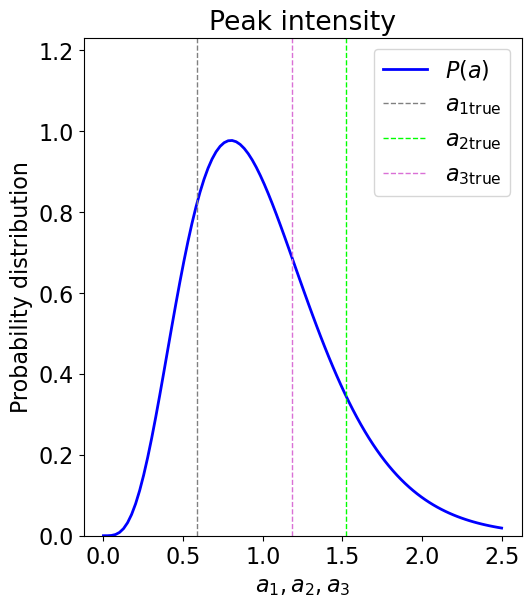

In [13]:
############################################
# 事前確率を描く横軸のポイント数
prob_points = 100
#
# a1_true  = 0.587
# a2_true  = 1.522
# a3_true  = 1.183
#
a_x = np.linspace(0, 2.5, num=prob_points, endpoint=True )
a_y = prior_a_func(a_x, prior_a_alpha, prior_a_beta)
#
############################################
ProbSets = [
    [ 0, a_x,     a_y,  r'$P(a)$',         'blue'   ],
    [ 1, a1_true, None, r'$a_{\rm 1true}$','gray'   ],
    [ 1, a2_true, None, r'$a_{\rm 2true}$','lime'   ],
    [ 1, a3_true, None, r'$a_{\rm 3true}$','orchid' ]
]
#
fig = grf_Prob( ProbSets, r'$a_{1}, a_{2}, a_{3}$', 'Peak intensity')
pdfName = FilePath + FileBaseName + '-Prior-a.pdf'
fig.savefig( pdfName )

$b_{1}$, $b_{2}$, $b_{3}$の事前確率

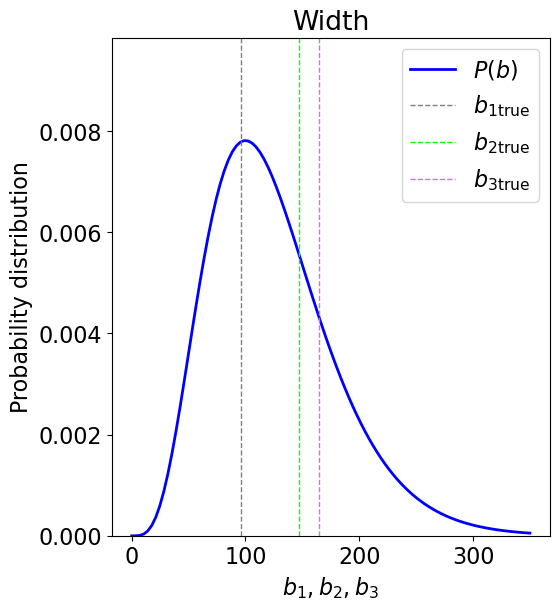

In [14]:
############################################
# 事前確率を描く横軸のポイント数
prob_points = 100
#
# b1_true  = 95.689
# b2_true  = 146.837
# b3_true  = 164.469
#
b_x = np.linspace(0, 350, num=prob_points, endpoint=True )
b_y = prior_b_func(b_x, prior_b_alpha, prior_b_beta)
#
############################################
ProbSets = [
    [ 0, b_x,     b_y,  r'$P(b)$',         'blue'   ],
    [ 1, b1_true, None, r'$b_{\rm 1true}$','gray'   ],
    [ 1, b2_true, None, r'$b_{\rm 2true}$','lime'   ],
    [ 1, b3_true, None, r'$b_{\rm 3true}$','orchid' ]
]
#
fig = grf_Prob( ProbSets, r'$b_{1}, b_{2}, b_{3}$', 'Width')
pdfName = FilePath + FileBaseName + '-Prior-b.pdf'
fig.savefig( pdfName )

---
3. MCMCを実行する関数

In [15]:
############################################
def MCMC_Metropolis( ydata, target_accept=0.8 ):
    # # for demo
    # np.random.seed(seed=1)
    #
    with pm.Model() as  model:
        #
        mu1 = pm.Normal('mu1', mu   =prior_mu_mu,   sigma=prior_mu_sd )
        a1  = pm.Gamma('a1',   alpha=prior_a_alpha, beta =prior_a_beta )
        b1  = pm.Gamma('b1',   alpha=prior_b_alpha, beta =prior_b_beta )
        #
        mu2 = pm.Normal('mu2', mu=prior_mu_mu,      sigma=prior_mu_sd )
        a2  = pm.Gamma('a2',   alpha=prior_a_alpha, beta =prior_a_beta )
        b2  = pm.Gamma('b2',   alpha=prior_b_alpha, beta =prior_b_beta )
        #
        mu3 = pm.Normal('mu3', mu=prior_mu_mu,      sigma=prior_mu_sd )
        a3  = pm.Gamma('a3',   alpha=prior_a_alpha, beta =prior_a_beta )
        b3  = pm.Gamma('b3',   alpha=prior_b_alpha, beta =prior_b_beta )
        #
        rmsd = pm.Uniform('rmsd', lower=prior_rmsd_lower, upper=prior_rmsd_upper )
        #
        y    = pm.Normal('y',mu=Gauss3(X, a1, mu1, b1, a2, mu2, b2, a3, mu3, b3 ), \
                             sigma=rmsd, observed=ydata)
        #
        step  = pm.Metropolis( target_accept = target_accept )
        #
        return pm.sample(20000, tune=10000, step=step, chains=2 )
#
############################################
def MCMC_NUTS( ydata, target_accept=0.8 ):
    # # for demo
    # np.random.seed(seed=1)
    #
    with pm.Model() as  model:
        #
        mu1 = pm.Normal('mu1', mu   =prior_mu_mu,   sigma=prior_mu_sd )
        a1  = pm.Gamma('a1',   alpha=prior_a_alpha, beta =prior_a_beta )
        b1  = pm.Gamma('b1',   alpha=prior_b_alpha, beta =prior_b_beta )
        #
        mu2 = pm.Normal('mu2', mu=prior_mu_mu,      sigma=prior_mu_sd )
        a2  = pm.Gamma('a2',   alpha=prior_a_alpha, beta =prior_a_beta )
        b2  = pm.Gamma('b2',   alpha=prior_b_alpha, beta =prior_b_beta )
        #
        mu3 = pm.Normal('mu3', mu=prior_mu_mu,      sigma=prior_mu_sd )
        a3  = pm.Gamma('a3',   alpha=prior_a_alpha, beta =prior_a_beta )
        b3  = pm.Gamma('b3',   alpha=prior_b_alpha, beta =prior_b_beta )
        #
        rmsd = pm.Uniform('rmsd', lower=prior_rmsd_lower, upper=prior_rmsd_upper )
        #
        y    = pm.Normal('y',mu=Gauss3(X, a1, mu1, b1, a2, mu2, b2, a3, mu3, b3 ), \
                             sigma=rmsd, observed=ydata)
        #
        step  = pm.NUTS( target_accept = target_accept )
        #
        return pm.sample(20000, tune=10000, step=step, chains=2 )

---
サンプリング結果をpickles ファイルとして保存する。
* https://docs.python.org/ja/3/library/pickle.html
* MCMCサンプリングは時間がかかるので、後処理の解析をやり直す場合、このpickleファイルを読み込んで行う。

In [16]:
############################################
def SaveTrace( file_fpath, trace ):
    print( 'Saving pickle file = %s' % file_fpath )
    with open( file_fpath, mode='wb') as f:
        pickle.dump(trace, f)
#
############################################
def LoadTrace( file_fpath):
  return pickle.load( open( file_fpath, mode='rb') )

---
4. NUTSサンプラーによるMCMCサンプリングの実行
  * pymc.NUTS: https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.NUTS.html
  * TheNo-U-Turn Sampler:Adaptively Setting Path Lengths in Hamiltonian Monte Carlo: Matthew D. Hoffman, Andrew Gelman, https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf
  * トレースを保存したpickleファイルが存在する場合、それを利用するか?、再度サンプリングし直すか?を選択する。

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1, a1, b1, mu2, a2, b2, mu3, a3, b3, rmsd]


Output()

Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 205 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Saving pickle file = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-trace.pkl


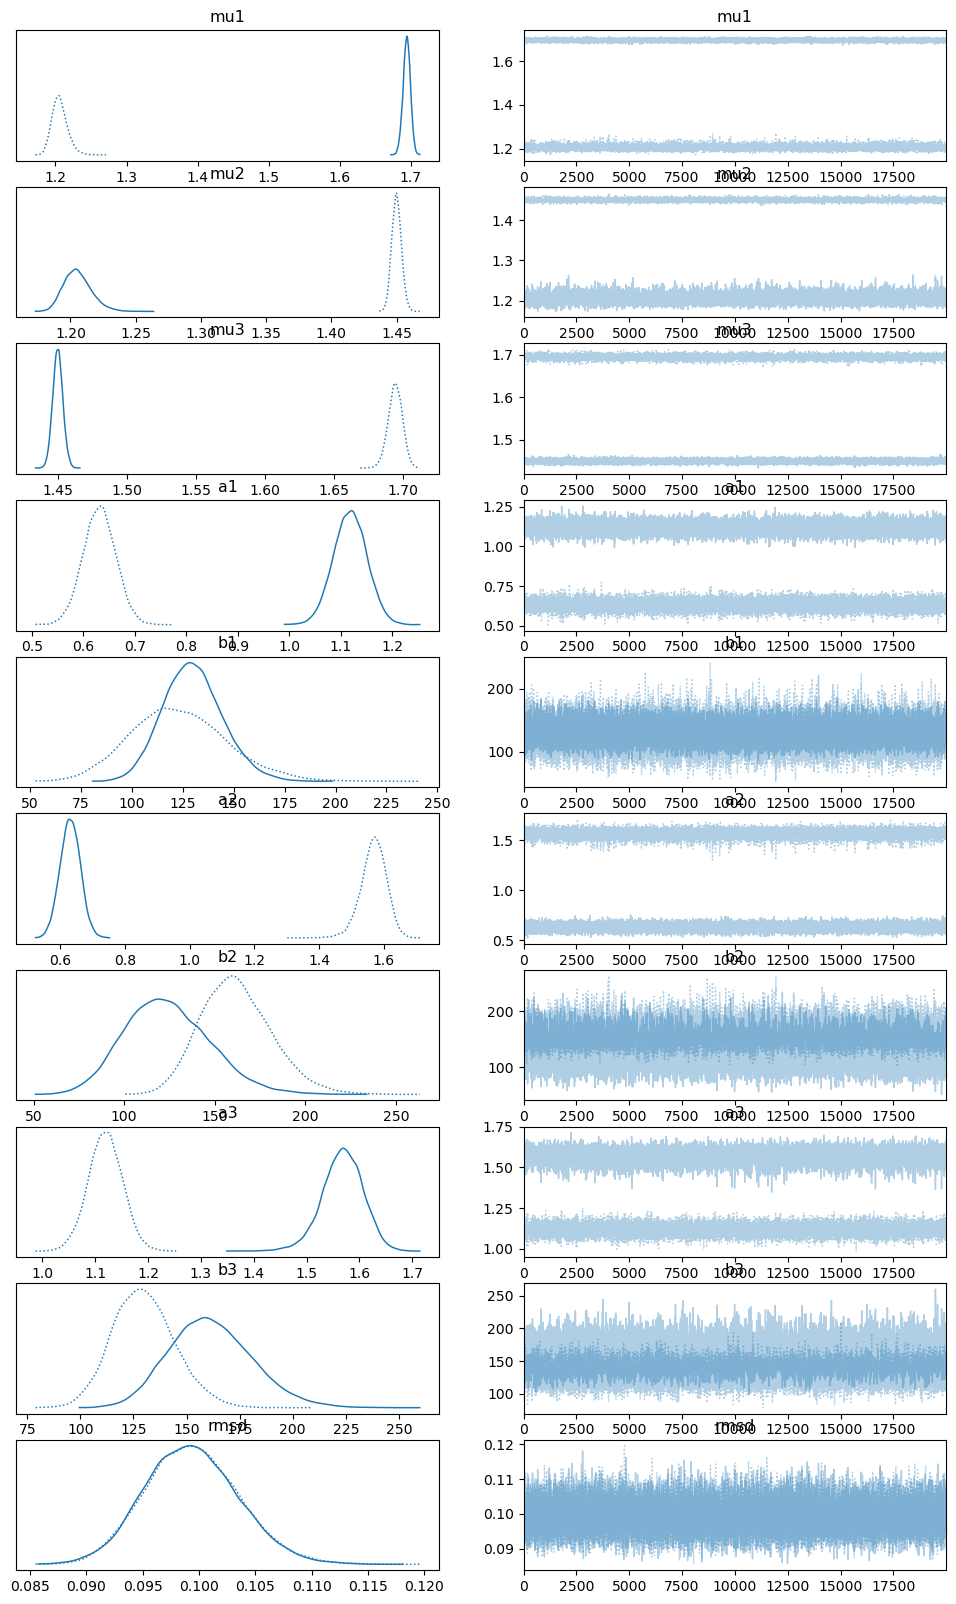

In [17]:
############################################
target_accept = 0.8
#
samplerName = 'NUTS'
# samplerName = 'Metropolis'
#
file_BaseName = FilePath + FileBaseName + '-' + samplerName + '-'
# pdf
pdfName = file_BaseName + 'trace.pdf'
# pickle
pklfName = file_BaseName + 'trace.pkl'
#
############################################
run_sampling = True
#
if True == os.path.isfile(pklfName):
  #
  msg = 'Already exists!: ' + pklfName + '\n' + 'Do you run samplings again?'
  #
  if True != YESorNO( msg ):
    run_sampling = False
#
############################################
if run_sampling:
  ##########################################
  if samplerName == 'NUTS':
    trace1 = MCMC_NUTS( Y, target_accept = target_accept )
  elif samplerName == 'Metropolis':
    trace1 = MCMC_Metropolis( Y, target_accept = target_accept )
  #
  ############################################
  pm.plot_trace(trace1)
  plt.savefig( pdfName )
  #
  ############################################
  SaveTrace( pklfName, trace1 )
#
else:
  trace1 = LoadTrace( pklfName )
  pm.plot_trace(trace1)
#

5. うまく終わったように見える?

2つの独立したサンプリングの履歴と事後確率分布が、類似していないかもしれない。
  * この例では、3つのスペクトル成分を同一スペクトル関数で、それらのパラメータの事前確率を同一にした。
  * その場合3つのスペクトル成分を区別するすべはなく、その結果、独立したサンプリングでは、3つのスペクトル成分が入れ替わってしまうことがある。

6. MCMCサンプリング結果のsummary

ここで得られる平均値は、独立したサンプリングの全体で評価されるので以下の真値と大きく異る。
$$
\begin{array}{|c||c|c|c|}
\hline
成分 & a_k & \mu_k & b_k \\
\hline\hline
k=1 & 0.587 & 1.210 & 95.689 \\
\hline
k=2 & 1.522 & 1.455 & 146.837 \\
\hline
k=3 & 1.183 & 1.703 & 164.469 \\
\hline
\end{array}
$$

In [18]:
############################################
pm.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,1.450,0.244,1.192,1.703,0.173,0.000,3.0,37.0,1.83
mu2,1.328,0.122,1.192,1.457,0.086,0.000,3.0,36.0,1.83
mu3,1.572,0.122,1.444,1.702,0.086,0.000,3.0,36.0,1.83
a1,0.875,0.246,0.581,1.168,0.173,0.000,3.0,38.0,1.83
b1,126.610,19.831,87.683,164.194,2.134,3.152,75.0,47.0,1.05
a2,1.099,0.470,0.584,1.626,0.331,0.000,3.0,38.0,1.83
b2,142.926,28.941,88.398,193.506,14.461,0.142,4.0,39.0,1.40
a3,1.344,0.227,1.070,1.628,0.159,0.000,3.0,37.0,1.83
b3,145.634,23.402,106.375,190.621,11.965,0.189,4.0,39.0,1.44
rmsd,0.099,0.004,0.092,0.107,0.000,0.000,35401.0,27423.0,1.00


---
1. $\theta_{t}$ ($t=1,2,\cdots,T$)の履歴でラグ$\Delta\tau$だけずらした要素を準備し、それぞれで平均値を求める。
$$
\langle\theta\rangle_{0}
=
\left\langle
\sum_{\tau=1}^{T-\Delta\tau}
\theta_{\tau}
\right\rangle
$$
$$
\langle\theta\rangle_{\Delta\tau}
=
\left\langle
  \sum_{\tau^\prime=1+\Delta\tau}^{T}
  \theta_{\tau^\prime}
\right\rangle
$$

2. 平均値と各履歴の差を求め、各履歴同士の積を計算し、その平均値を、$\Delta\tau$の共分散として求める。
$$
{\rm Cov}(\Delta\tau)
:=
\frac{
  \displaystyle
  \left\langle
  \sum_{\tau=1}^{T-\Delta\tau}
  \left[
    \theta_{\tau}
    -
    \langle\theta\rangle_{0}
  \right]
  \left[
    \theta_{\tau+\Delta\tau}
    -
    \langle\theta\rangle_{\Delta\tau}
  \right]
  \right\rangle
}{\sigma^{2}}
,
$$

ここで$\sigma^{2}$は次式で定義される$\theta_{\tau}$の分散である。
$$
\sigma^{2}
:=
\left\langle
  \sum_{\tau=1}^{T}
    \left[
      \theta_{\tau}
      -
      \langle\theta\rangle
    \right]^{2}
\right\rangle
,
\;\;\;\;
\langle\theta\rangle
=
\left\langle
  \sum_{\tau=1}^{T}
      \theta_{\tau}
\right\rangle
$$

In [19]:
############################################
def hist_cov( trace_, dtau ):
  if dtau == 0:
    # Δτ だけずらした要素を準備
    trace_0 = trace_
    trace_1 = trace_
  else:
    # Δτ だけずらした要素を準備
    trace_0 = trace_[dtau:]
    trace_1 = trace_[:-dtau]
  #
  # それぞれで平均値を求める
  mean_0 = np.mean( trace_0 )
  mean_1 = np.mean( trace_1 )
  #
  # 平均値と各履歴の差
  diff_0 = trace_0 - mean_0
  diff_1 = trace_1 - mean_1
  #
  # 各履歴同士の積を計算し、その平均値を求める
  return( np.mean( diff_0 * diff_1 ) )

3. ${\rm Cov}(\Delta\tau)$の時間特性において、$\Delta\tau\approx0$の高速減衰の後に、相関の緩和が現れる[J. Phys. Soc. Jpn. **65**, 1604 (1996)](https://journals.jps.jp/doi/pdf/10.1143/JPSJ.65.1604)。そのためFast成分とSlow成分を含んだ次式で回帰し、相関MCS $\mathcal{T}_\textrm{Slow}$を推定する。 ${\rm Cov}(\Delta\tau)$は、${\rm Cov}(0)=1$と規格化されているので、回帰式は以下の通り。
$$
{\rm Cov}(\Delta\tau)
\approx
(1-C_\textrm{Slow})
\exp
\left(
  -
  \frac{\Delta\tau}{\mathcal{T}_\textrm{Fast}}
\right)
+
C_\textrm{Slow}
\exp
\left(
  -
  \frac{\Delta\tau}{\mathcal{T}_\textrm{Slow}}
\right)
$$

In [20]:
############################################
def Cov_ExpDamp(x, T0, C, T):
  return (1-C) * np.exp( - x / T0 ) + C * np.exp( - x / T )
#
############################################
def Cov_ExpDampComps(x, T0, C, T):
  y0 = (1-C)*np.exp( - x / T0 )
  y1 = C * np.exp( - x / T )
  #
  return y0, y1, y0+y1

4. scipy.optimize.least squares()

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
```
result = scipy.optimize.least_squares( residual, theta0, bounds=(-inf, inf), method='trf' )
```
* residual: 残差を計算する関数
* theta0: 探索初期値
* bounds: 探索範囲の指定
* method:
  * 'trf' : Trust Region Reflective algorithm
  * 'dogbox' : Dogleg algorithm with rectangular trust regions
  * 'lm' : Levenberg-Marquardt algorithm

5. 残差関数:
$${\rm{}Residual}(\boldsymbol{\theta};\boldsymbol{x}, \boldsymbol{y})=\boldsymbol{y}-g(\boldsymbol{x};\boldsymbol{\theta})$$

* 探索初期値: $\boldsymbol{\theta}_{0}=\{\mathcal{T}_\textrm{Fast}^{0}, C_\textrm{Slow}^{0},\mathcal{T}_\textrm{Slow}^{0}\}$
* least_squares()を用いた解の探索

In [21]:
############################################
# 残差関数
def Cov_residual(theta, x, y):
  T0, C, T = theta[0], theta[1], theta[2]
  return y - Cov_ExpDamp(x, T0, C, T)

6. ${\rm Cov}(\Delta\tau)$のグラフを描く

In [22]:
############################################
# y_fits = [ [ y_fit, y_label, linestyle, color ], ]
############################################
def GrfCov( x_data, y_cov, y_fits, grf_title ):
  #
  plt.rcParams['font.size'] = 24
  #
  fig = plt.figure( figsize=(9,8) )
  #
  fig.subplots_adjust(left=0.15, right=0.93, top=0.95, bottom=0.12)
  #
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_xlabel( r'$\Delta\tau$ (MCSs)' )
  ax1.set_ylabel( r'${\rm Cov}(\Delta\tau)$' )
  ax1.set_ylim(-0.15, 1.15)
  #
  ax1.scatter( x_data, y_cov, color='black',
               label=r'${\rm Cov}(\Delta\tau)$', s=20 )
  #
  for y_fit in y_fits:
    #
    y_fit_data      = y_fit[ 0 ]
    y_fit_label     = y_fit[ 1 ]
    y_fit_linestyle = y_fit[ 2 ]
    y_fit_color     = y_fit[ 3 ]
    #
    ax1.plot( x_data, y_fit_data, color=y_fit_color, linestyle=y_fit_linestyle,
              linewidth=2, label=y_fit_label )
  #
  ax1.legend( fontsize=16 )
  #
  plt.title( grf_title )
  plt.show()
  #
  return fig

7. 各 chain において、各 key に対して、
  1. $\Delta\tau=0 \sim 200~{\rm MCSs}$の範囲で ${\rm Cov}(\Delta\tau)$を計算。
  2. その結果を、次式で最小二乗法により解析して、緩和時間$\mathcal{T}_\textrm{Slow}$を推定。
  $$
  {\rm Cov}(\Delta\tau)
  \approx
  (1-C_\textrm{Slow})
  \exp
  \left(
    -
    \frac{\Delta\tau}{\mathcal{T}_\textrm{Fast}}
  \right)
  +
  C_\textrm{Slow}
  \exp
  \left(
    -
    \frac{\Delta\tau}{\mathcal{T}_\textrm{Slow}}
  \right)
  $$

* 探索初期値は、$\mathcal{T}_\textrm{Fast}^{0}=1.0~\textrm{MCSs}$、$C_\textrm{Slow}^{0}=0.1$、$\mathcal{T}_\textrm{Slow}^{0}=5.0~\textrm{MCSs}$とする。
* パラメータは全て正値とし、$\mathcal{T}_\textrm{Fast}$, $\mathcal{T}_\textrm{Slow}$の上限値は解析対処範囲MCSsの2倍、$C_\textrm{Slow}$の上限は1とする。

それの結果をグラフ出力

In [23]:
############################################
def CovDecayMCSs( trace_, dtau_max=200, T0init=1.0, Cinit=0.1, Tinit=5.0 ):
  #
  msg_ = '***** Estimating Cov Decay MCSs *****'
  print( msg_ )
  #
  T_opt_longest_chains = np.infty
  T_opt_longest_chain_number = -1
  msgs = []
  msgs.append( msg_ )
  #
  for chain_ in trace_.posterior.chain:
    # 各 chain に対して
    chain_ = int(chain_)
    #
    # 各 key に対して
    T_opt_longest = 0.0
    Key_T_opt_longest = ""
    #
    for key_ in trace_.posterior.keys():
      #
      # traceから chain, keyのデータを切り出す
      theta_trace = np.array( trace_.posterior[ key_ ][ chain_ ] )
      #
      N_iters = theta_trace.size
      #
      ############################################
      # Cov(Δτ)の計算
      x_dtau = []
      y_cov  = []
      #
      cov0 = hist_cov( theta_trace, 0 )
      #
      for dtau in range(dtau_max):
        x_dtau.append( dtau  )
        y_cov.append( hist_cov( theta_trace, dtau )/cov0 )
        #
      x_dtau = np.array( x_dtau )
      y_cov  = np.array( y_cov )
      #
      ############################################
      # 最小二乗法で　C * exp( -Δτ/T )として解析
      x_data = x_dtau
      x_data_max = np.amax(x_data)
      y_data = y_cov
      #
      ######################
      # 探索初期値
      theta0 = np.array( [ T0init, Cinit, Tinit ] )
      #
      ######################
      # result = opt.least_squares( residual, theta0, method='trf',args=(x_data,y_data), bounds=(0,+np.inf) )
      # result = opt.least_squares( Cov_residual, theta0, method='lm',args=(x_data,y_data) )
      # result = opt.least_squares( Cov_residualV2, theta0, method='lm',args=(x_data,y_data) )
      result = opt.least_squares( Cov_residual, theta0, bounds =[ [0,0,0],[2*x_data_max, 1.0, 2*x_data_max] ], args=(x_data,y_data) )
      T0_opt, C_opt, T_opt = result.x[0], result.x[1], result.x[2]
      #
      # T0_opt と T_opt の長短関係がひっくり返っていないか?
      if T0_opt > T_opt:
        T0_opt, T_opt = T_opt, T0_opt
        C_opt = 1.0 - C_opt
      #
      msg_ = '  chain = %d, N_iters = %d, key = %-8s, Fast(C=%.4f,T=%.3f MCSs), Slow(C=%.4f,T=%.3f MCSs)' % (chain_, N_iters, key_, (1-C_opt), T0_opt, C_opt, T_opt )
      msgs.append( msg_ )
      #
      if T_opt > T_opt_longest:
        T_opt_longest = T_opt
        Key_T_opt_longest = msg_
      #
      print(  msg_ )
      #
      # fit_ExpDamp = Cov_ExpDampV2( x_dtau, T0_opt, C_opt, T_opt)
      fit_ExpDampY0, fit_ExpDampY1, fit_ExpDamp = Cov_ExpDampComps( x_dtau, T0_opt, C_opt, T_opt)
      #
      fits_ExpDamp = [
          [ fit_ExpDampY0, r'Fast: $C=$%.4f, $\mathcal{T}=%.3f~{\rm MCSs}$' % ((1-C_opt),T0_opt ), 'dashed', 'lime' ],
          [ fit_ExpDampY1, r'Slow: $C=$%.4f, $\mathcal{T}=%.3f~{\rm MCSs}$' % (C_opt,T_opt ),      'dashed', 'blue' ],
          [ fit_ExpDamp,   r'Fast + Slow',                                                         'solid',  'red'  ]
      ]
      #
      ############################################
      Grftitle = key_ + " (chain=%d)" % chain_
      fig = GrfCov( x_dtau, y_cov, fits_ExpDamp, Grftitle )
      #
      pdfSubName = '%s%02d' % (key_, chain_)
      pdfName = FilePath + FileBaseName + '-' + samplerName + '-Cov-' + pdfSubName + '.pdf'
      print( pdfName )
      fig.savefig( pdfName )
    #
    msg_ = 'The longest: ' + Key_T_opt_longest
    msgs.append( msg_ )
    #
    print( msg_ )
    #
    if T_opt_longest < T_opt_longest_chains:
      T_opt_longest_chains = T_opt_longest
      T_opt_longest_chain_number = chain_
    #
  #
  msg_ = '***** Chain=%d has the shortest Cov Decy MCSs. *****' % T_opt_longest_chain_number
  msgs.append( msg_ )
  print( msg_ )
  #
  for msg_ in msgs:
    print( msg_ )
  #
  return T_opt_longest_chain_number

10. 各パラメータの履歴相関の緩和時間を調べ、一番短いchainを選択することとする。

* (a) 各chainにおいて、すべてのパラメータの$\mathcal{T}$を評価し、その中で、各chainでworstケースとなっているパラメータ、つまり一番長い$\mathcal{T}_\textrm{worst}$を求める。
* (b) 各chainの$\mathcal{T}_\textrm{worst}$を比較して、それが一番短いもを選択する。

ただしサンプラーがMetropolisの場合、緩和時間が長めになるので、対象範囲を調整している。

***** Estimating Cov Decay MCSs *****
  chain = 0, N_iters = 20000, key = mu1     , Fast(C=0.5920,T=0.006 MCSs), Slow(C=0.4080,T=1.297 MCSs)


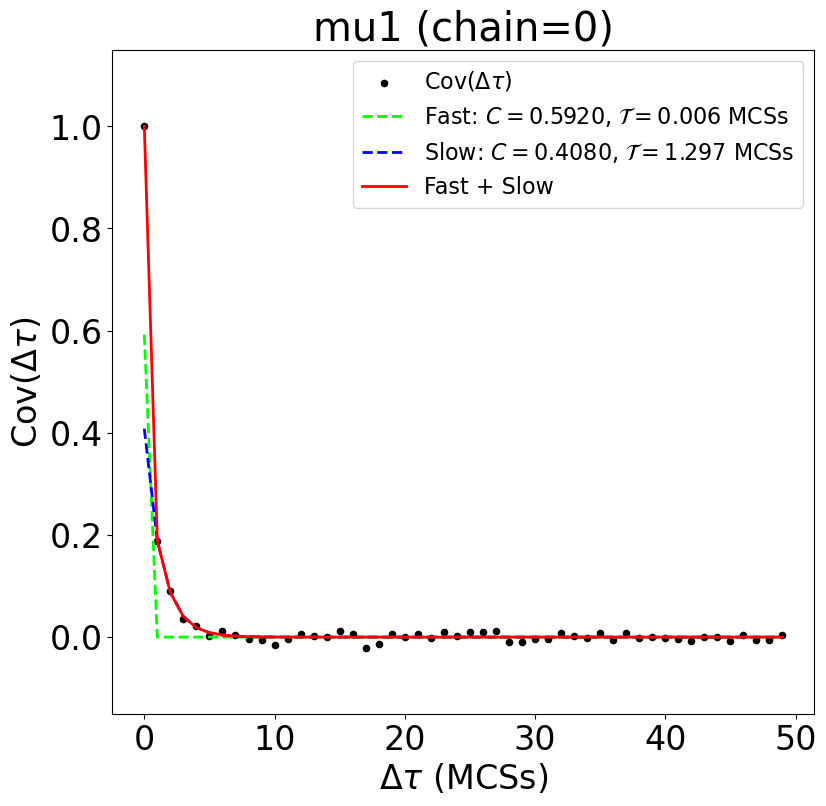

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-mu100.pdf
  chain = 0, N_iters = 20000, key = mu2     , Fast(C=0.3500,T=0.006 MCSs), Slow(C=0.6500,T=1.287 MCSs)


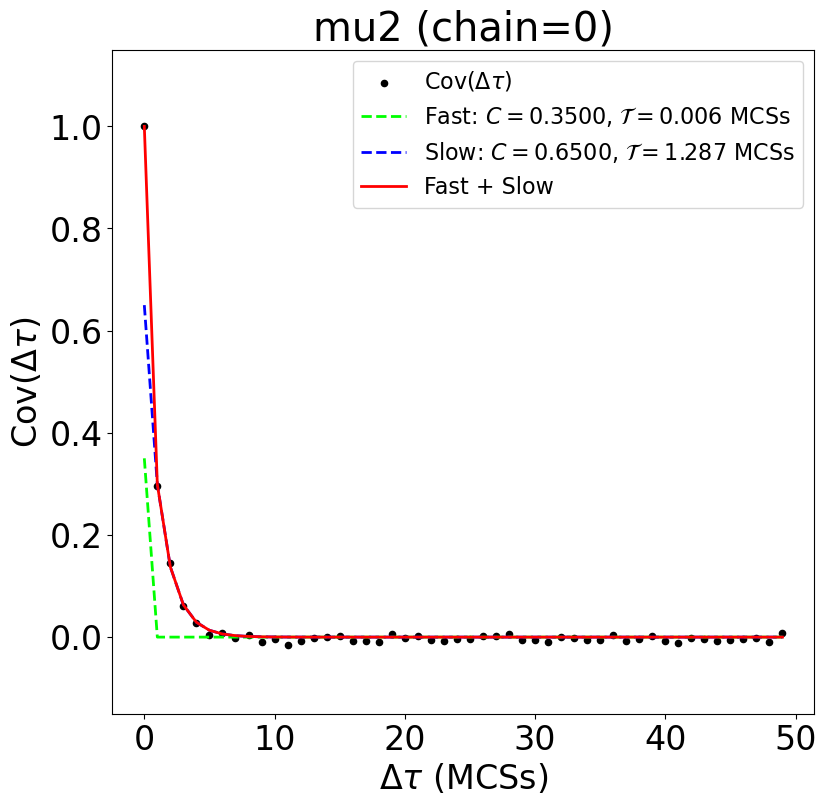

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-mu200.pdf
  chain = 0, N_iters = 20000, key = mu3     , Fast(C=0.7369,T=0.035 MCSs), Slow(C=0.2631,T=0.935 MCSs)


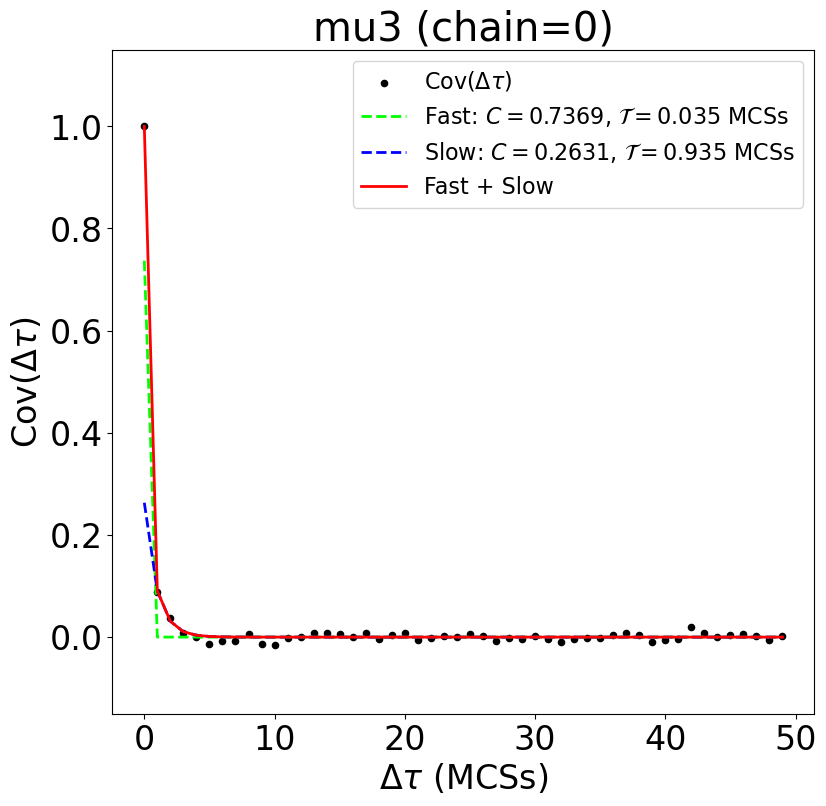

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-mu300.pdf
  chain = 0, N_iters = 20000, key = a1      , Fast(C=0.9526,T=0.019 MCSs), Slow(C=0.0474,T=0.909 MCSs)


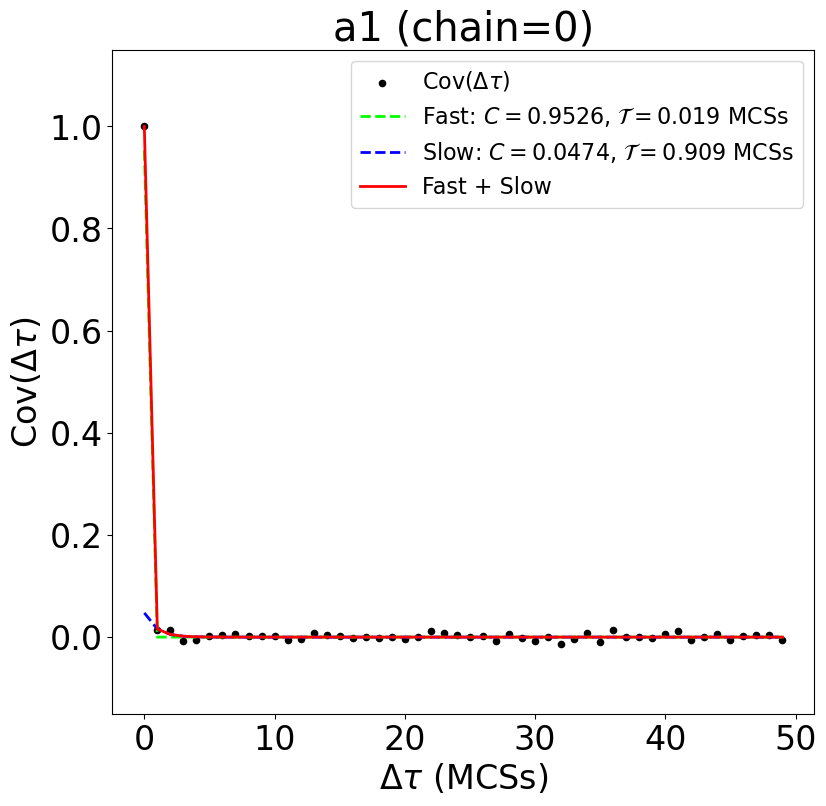

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-a100.pdf
  chain = 0, N_iters = 20000, key = b1      , Fast(C=0.6782,T=0.268 MCSs), Slow(C=0.3218,T=1.187 MCSs)


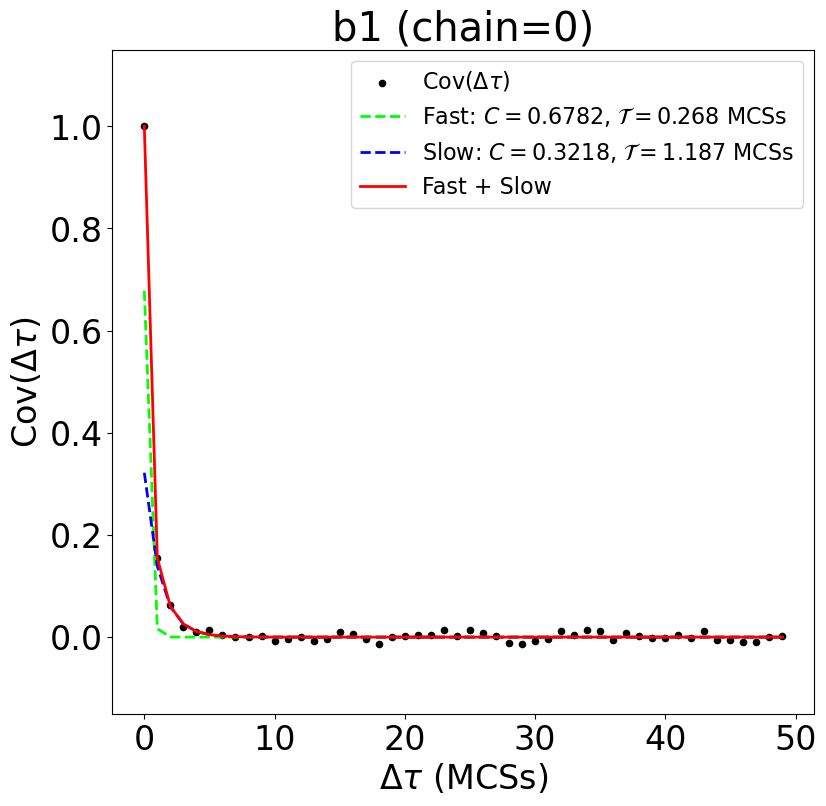

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-b100.pdf
  chain = 0, N_iters = 20000, key = a2      , Fast(C=1.0000,T=0.006 MCSs), Slow(C=0.0000,T=21.966 MCSs)


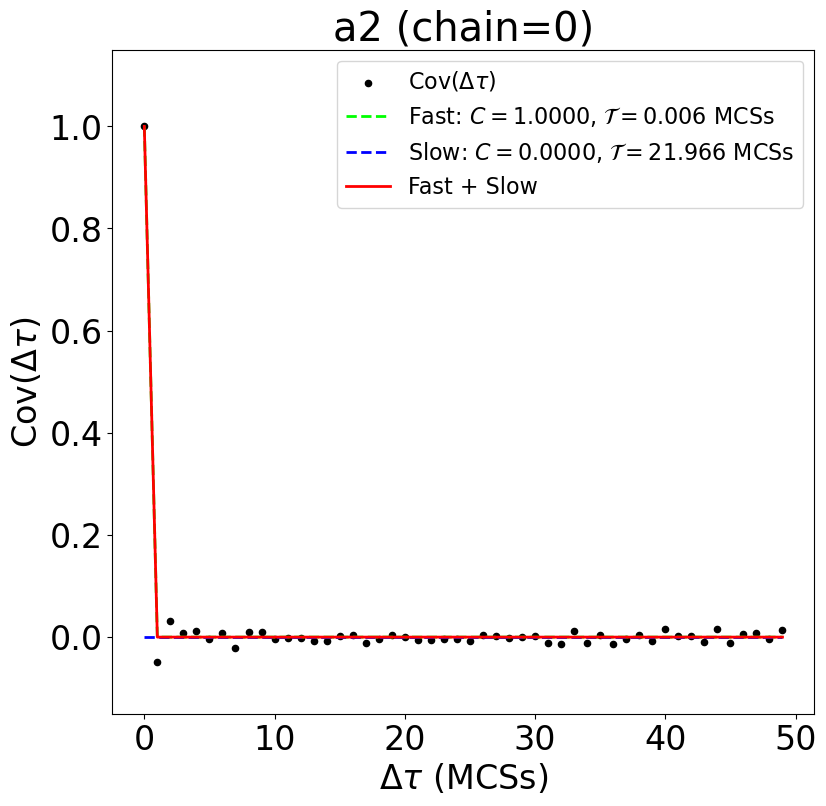

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-a200.pdf
  chain = 0, N_iters = 20000, key = b2      , Fast(C=0.4121,T=0.004 MCSs), Slow(C=0.5879,T=1.165 MCSs)


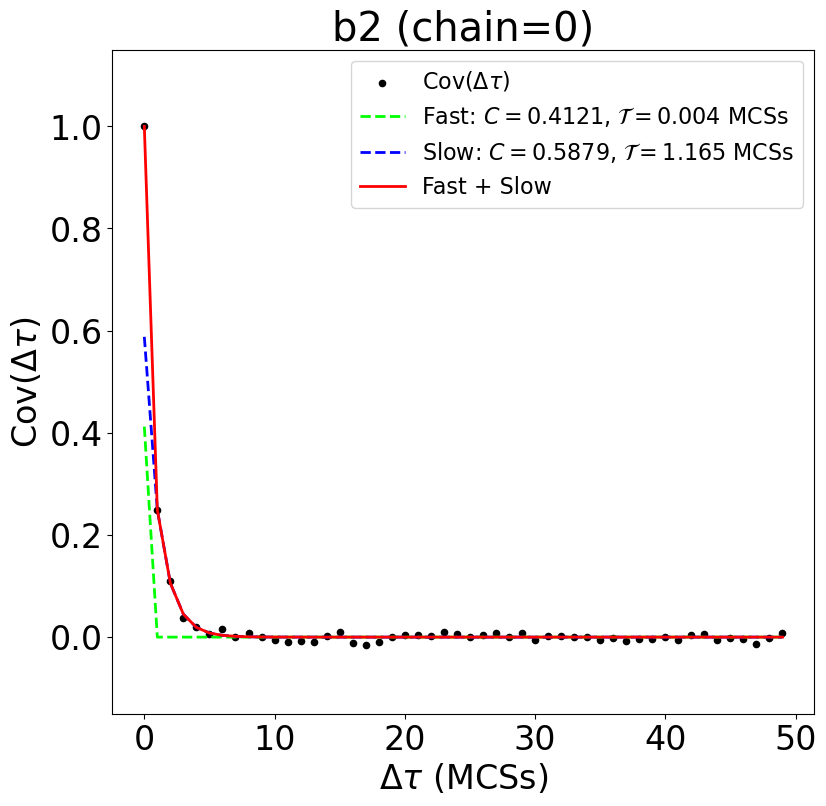

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-b200.pdf
  chain = 0, N_iters = 20000, key = a3      , Fast(C=0.9387,T=0.013 MCSs), Slow(C=0.0613,T=3.423 MCSs)


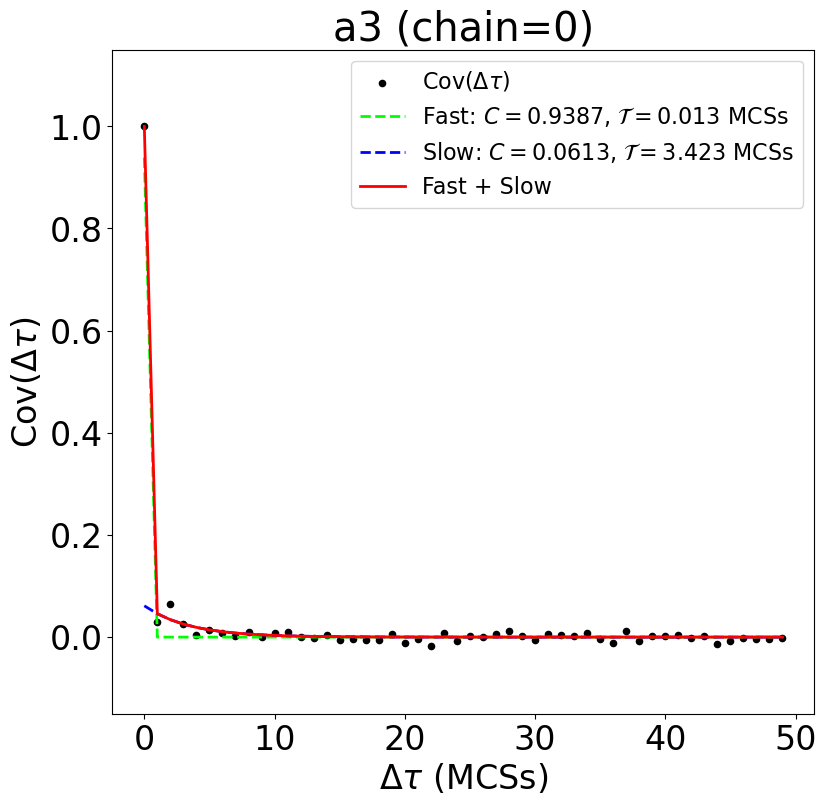

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-a300.pdf
  chain = 0, N_iters = 20000, key = b3      , Fast(C=0.3059,T=0.312 MCSs), Slow(C=0.6941,T=1.233 MCSs)


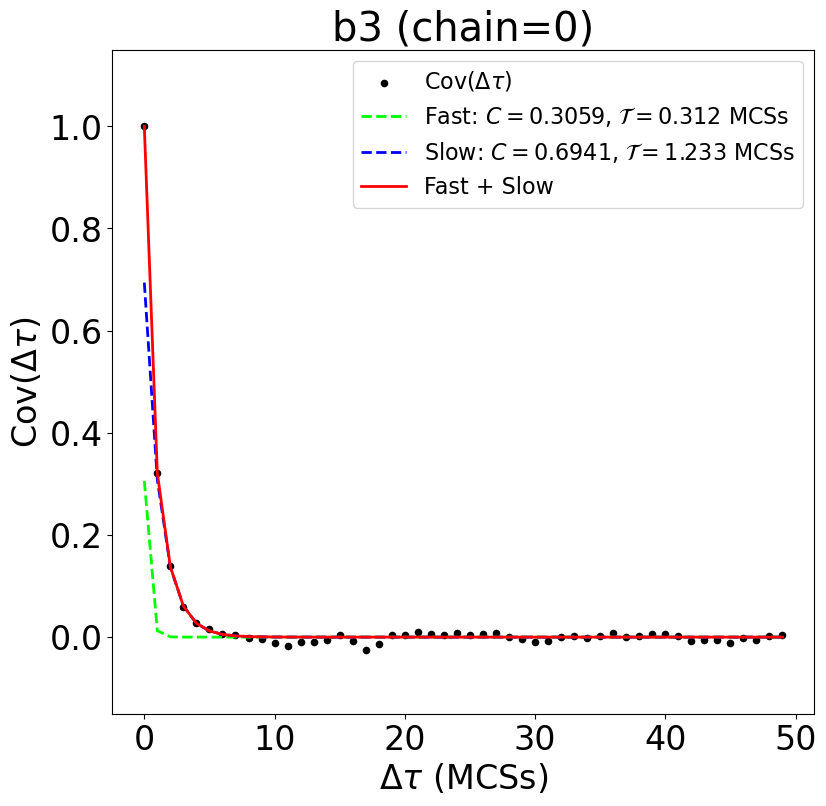

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-b300.pdf
  chain = 0, N_iters = 20000, key = rmsd    , Fast(C=0.9507,T=0.059 MCSs), Slow(C=0.0493,T=1.187 MCSs)


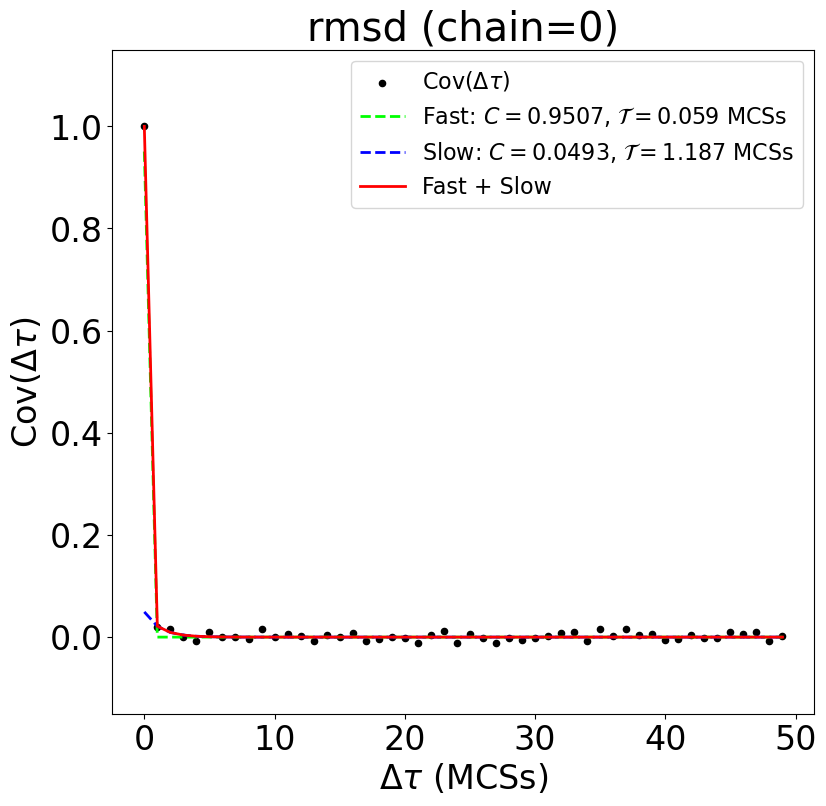

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-rmsd00.pdf
The longest:   chain = 0, N_iters = 20000, key = a2      , Fast(C=1.0000,T=0.006 MCSs), Slow(C=0.0000,T=21.966 MCSs)
  chain = 1, N_iters = 20000, key = mu1     , Fast(C=0.4955,T=0.275 MCSs), Slow(C=0.5045,T=1.232 MCSs)


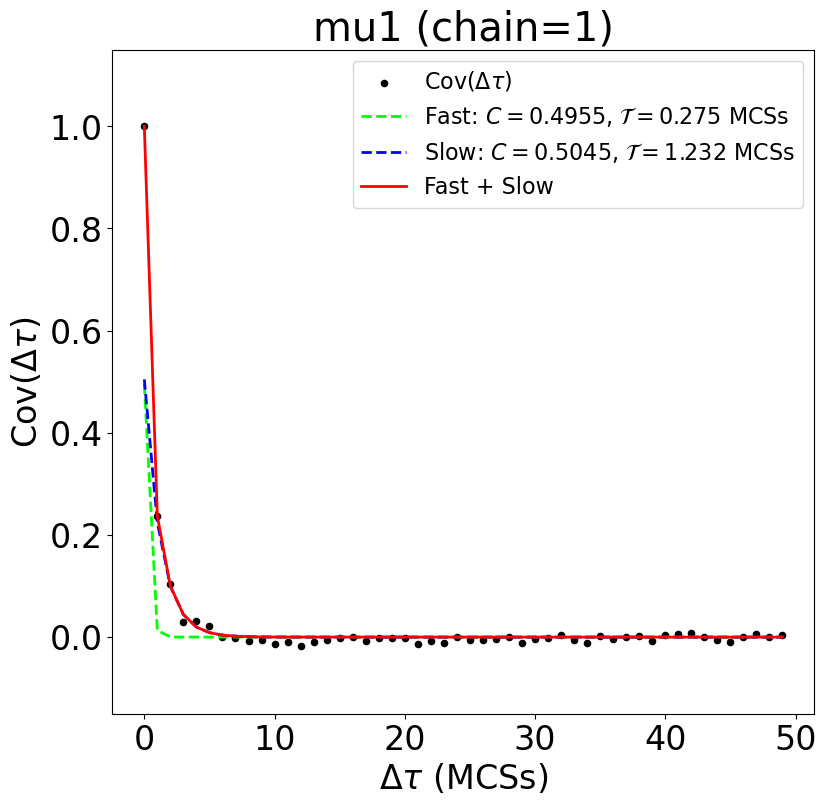

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-mu101.pdf
  chain = 1, N_iters = 20000, key = mu2     , Fast(C=0.9624,T=0.371 MCSs), Slow(C=0.0376,T=3.264 MCSs)


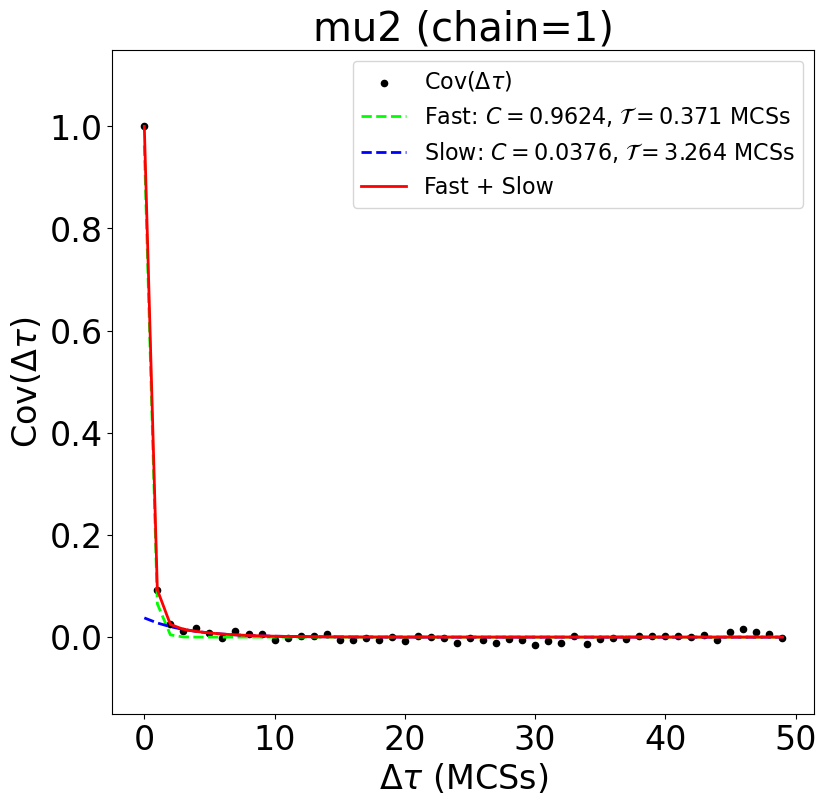

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-mu201.pdf
  chain = 1, N_iters = 20000, key = mu3     , Fast(C=0.6465,T=0.020 MCSs), Slow(C=0.3535,T=1.248 MCSs)


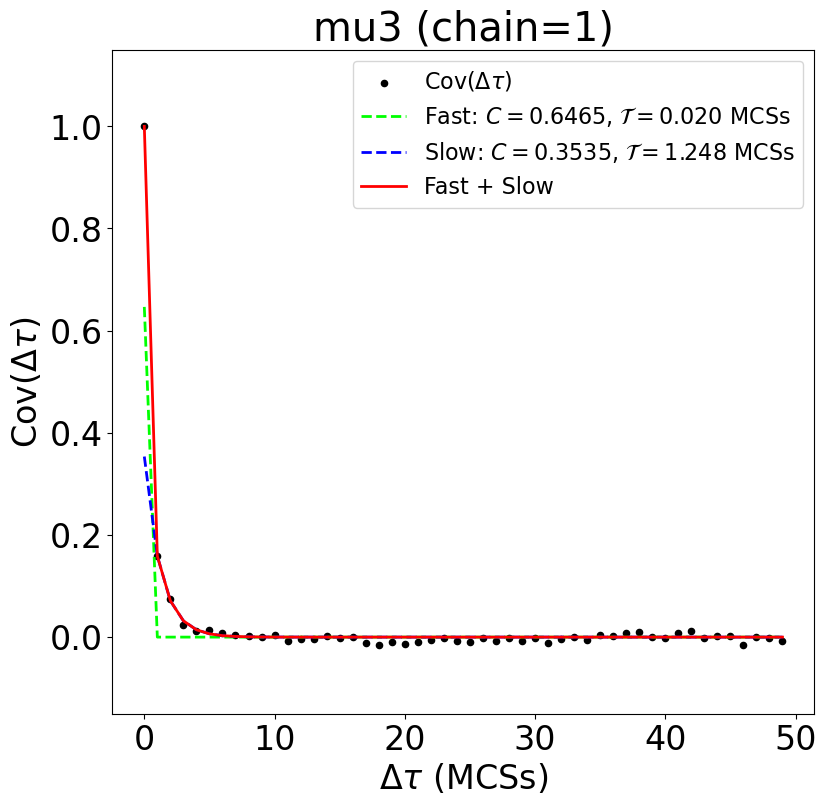

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-mu301.pdf
  chain = 1, N_iters = 20000, key = a1      , Fast(C=0.9998,T=0.006 MCSs), Slow(C=0.0002,T=26.887 MCSs)


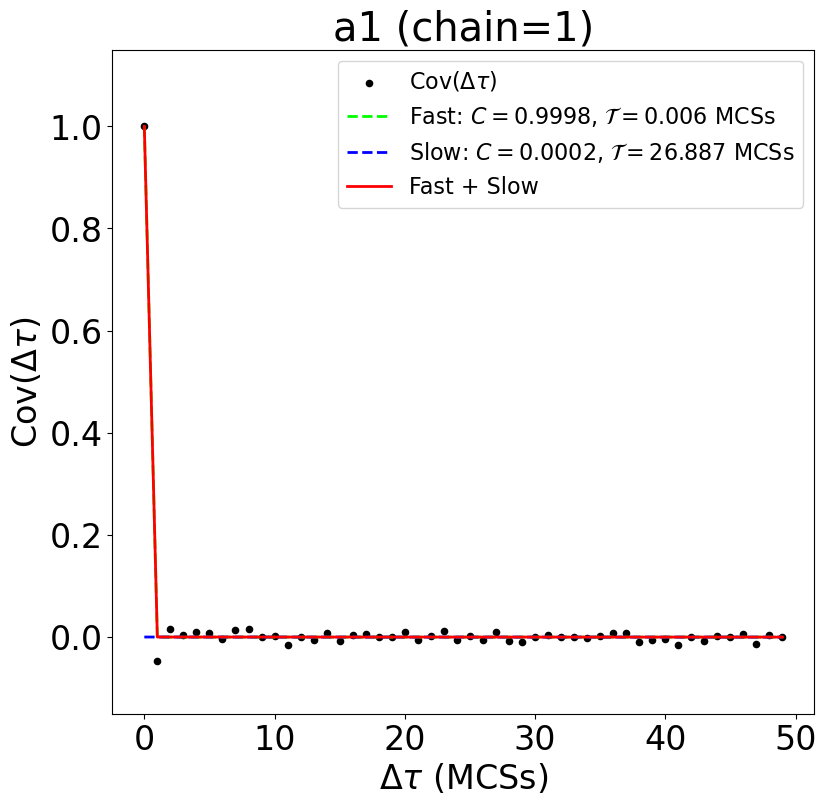

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-a101.pdf
  chain = 1, N_iters = 20000, key = b1      , Fast(C=0.7460,T=0.363 MCSs), Slow(C=0.2540,T=1.433 MCSs)


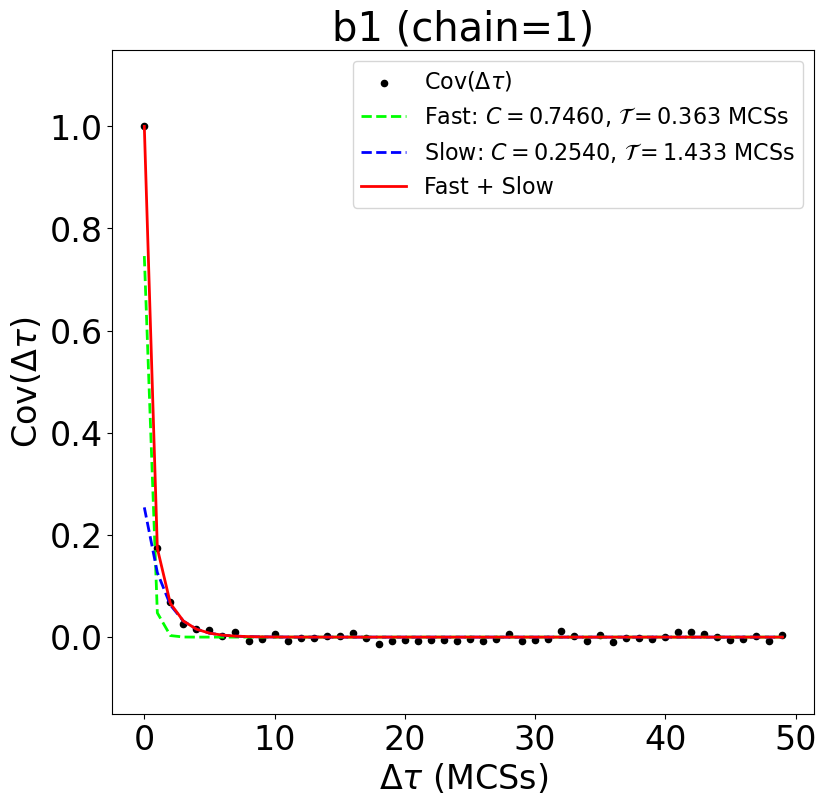

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-b101.pdf
  chain = 1, N_iters = 20000, key = a2      , Fast(C=0.9236,T=0.021 MCSs), Slow(C=0.0764,T=2.712 MCSs)


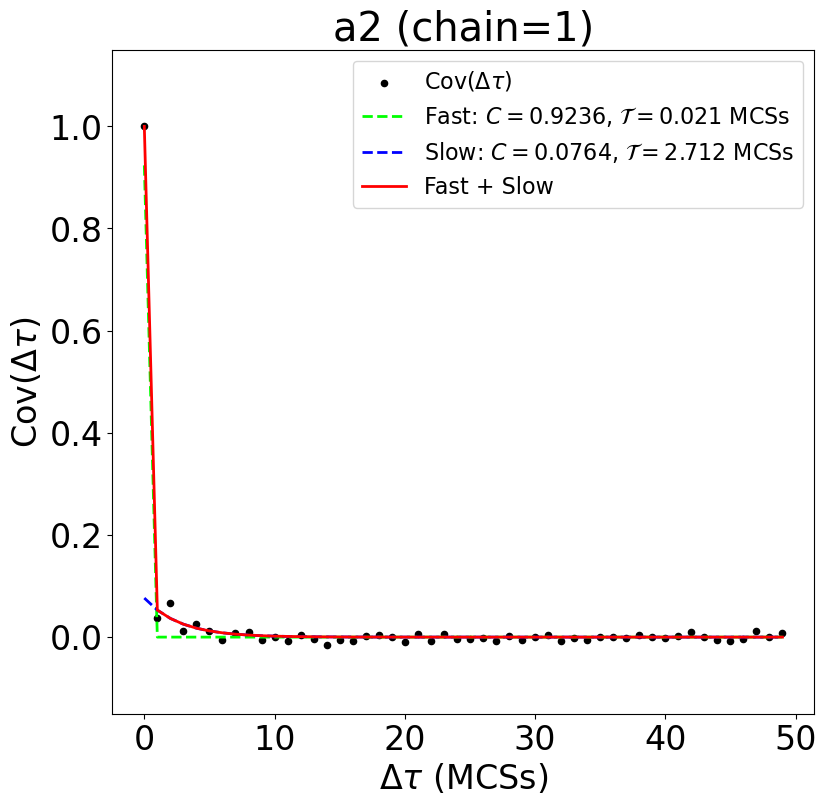

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-a201.pdf
  chain = 1, N_iters = 20000, key = b2      , Fast(C=0.5691,T=0.380 MCSs), Slow(C=0.4309,T=1.337 MCSs)


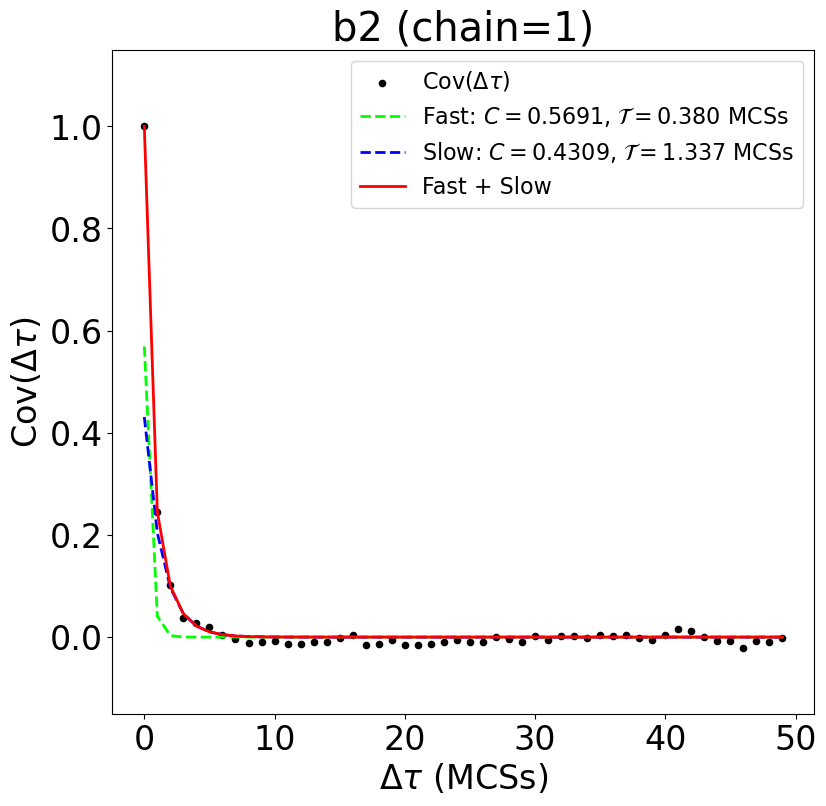

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-b201.pdf
  chain = 1, N_iters = 20000, key = a3      , Fast(C=0.9987,T=0.005 MCSs), Slow(C=0.0013,T=0.006 MCSs)


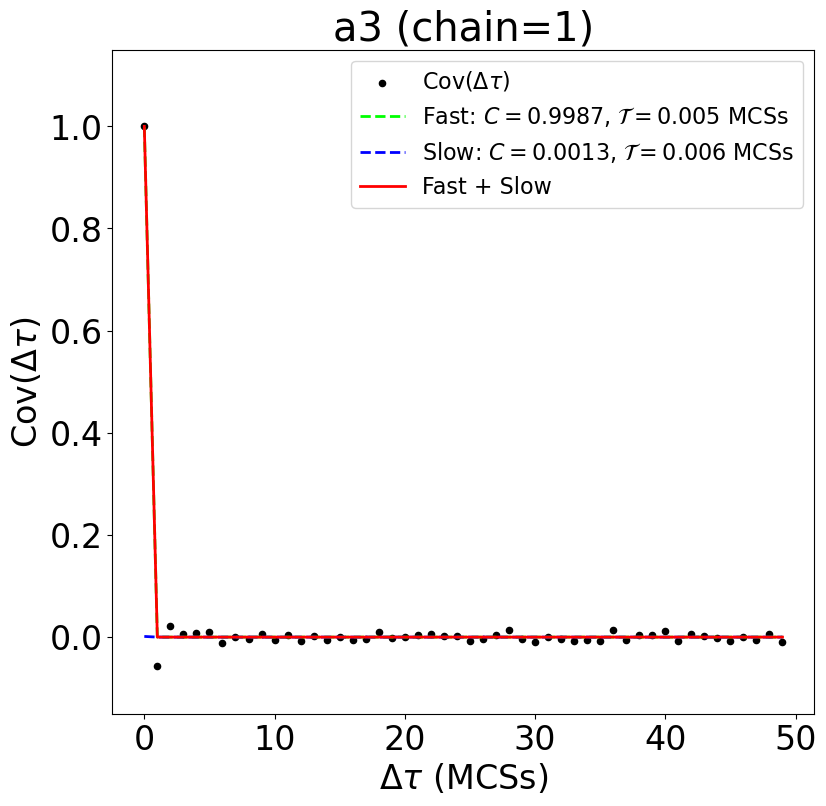

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-a301.pdf
  chain = 1, N_iters = 20000, key = b3      , Fast(C=0.7239,T=0.015 MCSs), Slow(C=0.2761,T=1.378 MCSs)


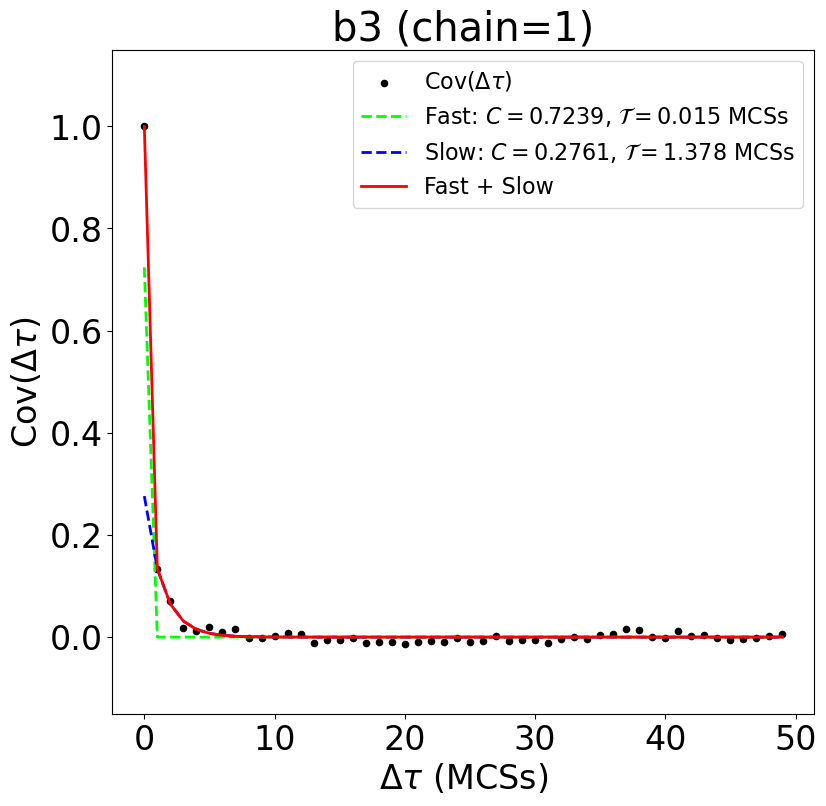

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-b301.pdf
  chain = 1, N_iters = 20000, key = rmsd    , Fast(C=0.9648,T=0.180 MCSs), Slow(C=0.0352,T=2.673 MCSs)


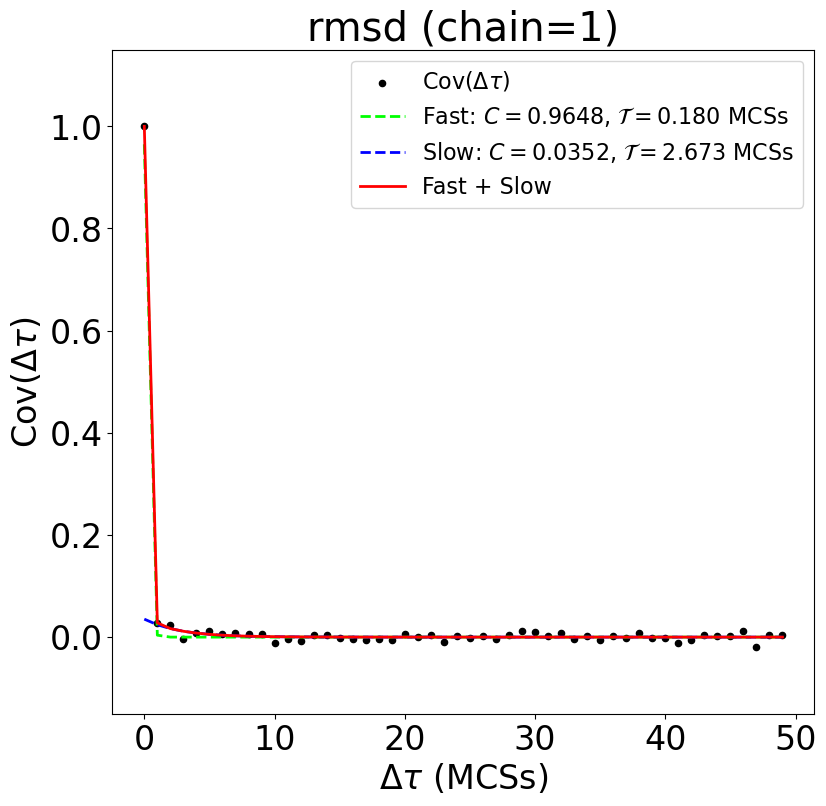

d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap02/2PyMC-07ThreePeaks-01NUTS/2PyMC-07ThreePeaks-01NUTS-NUTS-Cov-rmsd01.pdf
The longest:   chain = 1, N_iters = 20000, key = a1      , Fast(C=0.9998,T=0.006 MCSs), Slow(C=0.0002,T=26.887 MCSs)
***** Chain=0 has the shortest Cov Decy MCSs. *****
***** Estimating Cov Decay MCSs *****
  chain = 0, N_iters = 20000, key = mu1     , Fast(C=0.5920,T=0.006 MCSs), Slow(C=0.4080,T=1.297 MCSs)
  chain = 0, N_iters = 20000, key = mu2     , Fast(C=0.3500,T=0.006 MCSs), Slow(C=0.6500,T=1.287 MCSs)
  chain = 0, N_iters = 20000, key = mu3     , Fast(C=0.7369,T=0.035 MCSs), Slow(C=0.2631,T=0.935 MCSs)
  chain = 0, N_iters = 20000, key = a1      , Fast(C=0.9526,T=0.019 MCSs), Slow(C=0.0474,T=0.909 MCSs)
  chain = 0, N_iters = 20000, key = b1      , Fast(C=0.6782,T=0.268 MCSs), Slow(C=0.3218,T=1.187 MCSs)
  chain = 0, N_iters = 20000, key = a2      , Fast(C=1.0000,T=0.006 MCSs), Slow(C=0.0000,T=21.966 MCSs)
  chain = 0, N_ite

In [24]:
############################################
if samplerName == 'NUTS':
  chain_selected = CovDecayMCSs( trace1, dtau_max=50 )
elif samplerName == 'Metropolis':
  chain_selected = CovDecayMCSs( trace1, dtau_max=200 )
#
print( "Chain = %d was selected." % chain_selected )

選択したchainの統計情報を計算

In [25]:
############################################
chain_ = chain_selected
trace_ = trace1

サンプリングされた各値における事前確率の計算する関数

In [26]:
############################################
def calc_prior( df, param_name, func_prior, prior_param1, prior_param2 ):
  #
  prior_ = func_prior( df[ param_name ], prior_param1, prior_param2 )
  prior_ = prior_ / np.amax( prior_ )
  #
  return prior_

以下の統計情報を計算する
1. 平均値、事後確率分布の標準偏差、中央値
2. 最尤(MLE)推定値
3. サンプリングされた値での事前確率
4. 事後確率
5. MAP推定値

In [27]:
############################################
print( '**********************************' )
print( '* chain = %d' % chain_ )
df_trace = trace_.sel( chain=[chain_] ).posterior.to_dataframe()
#
##########################
# mean / standard deviation
print( '==================================' )
print( ' name   (count) = mean +/- std_dev' )
print( '----------------------------------' )
for idx in df_trace.columns:
  #
  data = np.array( df_trace[idx] )
  data_len = len( data )
  data_mean = np.mean( data )
  data_std  = np.std( data )
  #
  str_print = ' %-6s (%5d) = ' % ( idx, data_len )
  print( str_print +  Format_MostProbableValue( data_mean, data_std, '' ) )
#
##########################
# MLE
print( '==================================' )
data = np.array( df_trace['rmsd'] )
MLE_idx_  = np.argmin( df_trace['rmsd'] )
MLE_rmsd_ = data[MLE_idx_]
print( ' MLE    (%5d) rmsd = %.4E' % (MLE_idx_, MLE_rmsd_ ) )
print( ' name  (MLEidx) = MLE  (std_dev)' )
print( '----------------------------------' )
#
for idx in df_trace.columns:
  #
  data = np.array( df_trace[idx] )
  data_MLE = data[MLE_idx_]
  data_std = np.std( data )
  #
  str_print = ' %-6s (%5d) = ' % ( idx, MLE_idx_ )
  print( str_print +  Format_MostProbableValue( data_MLE, data_std, '', parens=True ) )
#
##########################
# prior
# # 1. P(mu)
# prior_mu_func = PNormal
# prior_mu_mu   = 1.5
# # prior_mu_sd   = 1.0 / np.sqrt(5.0)
# prior_mu_sd   = 1.0 / np.sqrt(10.0)
prior_mu1  = calc_prior( df_trace, 'mu1',   prior_mu_func,    prior_mu_mu,  prior_mu_sd    )
prior_mu2  = calc_prior( df_trace, 'mu2',   prior_mu_func,    prior_mu_mu,  prior_mu_sd    )
prior_mu3  = calc_prior( df_trace, 'mu3',   prior_mu_func,    prior_mu_mu,  prior_mu_sd    )
# #
# # 2. P(a)
# prior_a_func  = PGamma
# prior_a_alpha = 5.0
# prior_a_beta  = 5.0
prior_a1  = calc_prior( df_trace, 'a1',   prior_a_func,    prior_a_alpha,  prior_a_beta    )
prior_a2  = calc_prior( df_trace, 'a2',   prior_a_func,    prior_a_alpha,  prior_a_beta    )
prior_a3  = calc_prior( df_trace, 'a3',   prior_a_func,    prior_a_alpha,  prior_a_beta    )
# #
# # 3. P(b)
# prior_b_func  = PGamma
# prior_b_alpha = 5.0
# prior_b_beta  = 0.04
prior_b1  = calc_prior( df_trace, 'b1',   prior_b_func,    prior_b_alpha,  prior_b_beta    )
prior_b2  = calc_prior( df_trace, 'b2',   prior_b_func,    prior_b_alpha,  prior_b_beta    )
prior_b3  = calc_prior( df_trace, 'b3',   prior_b_func,    prior_b_alpha,  prior_b_beta    )
#
priors    = prior_mu1 * prior_a1 * prior_b1 * prior_mu2 * prior_a2 * prior_b2 * prior_mu3 * prior_a3 * prior_b3
df_trace[ 'priors'] = priors
#
##########################
# Likelihood
# $\sigma_\textrm{noise}$を用いて尤度を計算
likelihood = np.exp( - M * df_trace['rmsd']**2/(2.0*sigma_noise**2) )
likelihood = likelihood / np.amax( likelihood )
# print( np.argmax(likelihood) )
df_trace[ 'likelihood'] = likelihood
#
##########################
# 尤度と事前確率をかけて事後確率を計算
posterior = likelihood * priors
posterior = posterior / np.amax( posterior )
MAP_idx_  = np.argmax(posterior)
df_trace[ 'posterior'] = posterior
print( '==================================' )
print( ' MAP    (%5d)' % MAP_idx_ )
print( ' name  (MAPidx) = MAP  (std_dev)' )
print( '----------------------------------' )
#
for idx in df_trace.columns:
  #
  data = np.array( df_trace[idx] )
  data_MAP = data[MAP_idx_]
  data_std = np.std( data )
  #
  str_print = ' %-6s (%5d) = ' % ( idx, MAP_idx_ )
  print( str_print +  Format_MostProbableValue( data_MAP, data_std, '', parens=True ) )
#
##########################
# 統計量のまとめのデータフレームを用意
print( '==================================' )
print( 'Summary' )
print( '----------------------------------' )
df_summary = pd.DataFrame()
df_summary.index = df_trace.columns
df_summary.at[ 'mu1',  "true" ] = mu1_true
df_summary.at[ 'a1',   "true" ] = a1_true
df_summary.at[ 'b1',   "true" ] = b1_true
df_summary.at[ 'mu2',  "true" ] = mu2_true
df_summary.at[ 'a2',   "true" ] = a2_true
df_summary.at[ 'b2',   "true" ] = b2_true
df_summary.at[ 'mu3',  "true" ] = mu3_true
df_summary.at[ 'a3',   "true" ] = a3_true
df_summary.at[ 'b3',   "true" ] = b3_true
df_summary.at[ 'rmsd', "true" ] = sigma_noise
#
##########################
# 統計量(サンプリング数、最大値、最小値、平均値、標準偏差、中央値、MLE値, MAP値)
for idx in df_trace.columns:
  data = np.array( df_trace[idx] )
  #
  data_len = len( data )
  df_summary.at[ idx, "length" ]  = data_len
  df_summary.at[ idx, "max"    ]  = np.amax( data )
  df_summary.at[ idx, "min"    ]  = np.amin( data )
  data_mean = np.mean( data )
  df_summary.at[ idx, "mean"   ]  = data_mean
  data_std  = np.std( data )
  df_summary.at[ idx, "std"    ]  = np.std( data )
  df_summary.at[ idx, "median" ]  = np.median( data )
  #
  data_MLE = df_trace[idx].iat[ MLE_idx_ ]
  df_summary.at[ idx, "MLE"    ]  = data_MLE
  data_MAP = df_trace[idx].iat[ MAP_idx_ ]
  df_summary.at[ idx, "MAP"    ]  = data_MAP
  #
  str_print = ' %-6s (%5d), MEAN = ' % ( idx, data_len )
  str_print = str_print + Format_MostProbableValue( data_mean, data_std, '' )
  str_print = str_print + ', MAP = '
  str_print = str_print + Format_MostProbableValue( data_MAP, data_std, '', parens=True )
  str_print = str_print + ', MLE = '
  str_print = str_print + Format_MostProbableValue( data_MLE, data_std, '', parens=True )
  #
  print( str_print )

**********************************
* chain = 0
 name   (count) = mean +/- std_dev
----------------------------------
 mu1    (20000) = +1.6945 +/- 0.0052 
 mu2    (20000) = +1.206 +/- 0.011 
 mu3    (20000) = +1.4500 +/- 0.0036 
 a1     (20000) = +1.119 +/- 0.033 
 b1     (20000) = +130 +/- 15 
 a2     (20000) = (+63.1 +/- 3.1)x10^(-2) 
 b2     (20000) = +124 +/- 24 
 a3     (20000) = +1.568 +/- 0.039 
 b3     (20000) = +161 +/- 19 
 rmsd   (20000) = (+99.3 +/- 4.1)x10^(-3) 
 MLE    (12487) rmsd = 8.5699E-02
 name  (MLEidx) = MLE  (std_dev)
----------------------------------
 mu1    (12487) = +1.6898 (0.0052) 
 mu2    (12487) = +1.217 (0.011) 
 mu3    (12487) = +1.4511 (0.0036) 
 a1     (12487) = +1.109 (0.033) 
 b1     (12487) = +121 (15) 
 a2     (12487) = (+62.7 [3.1])x10^(-2) 
 b2     (12487) = +100 (24) 
 a3     (12487) = +1.582 (0.039) 
 b3     (12487) = +188 (19) 
 rmsd   (12487) = (+85.7 [4.1])x10^(-3) 
 MAP    (12487)
 name  (MAPidx) = MAP  (std_dev)
--------------------------

事後確率分布、事前確率、各値(平均値、MODE値、等)を表示する関数

In [28]:
############################################
# theta_marks = [ ['name1', value1, color1, linestyle1],
#                 ['name2', value2, color2, linestyle2] ]
############################################
def grf_PthetaD( trace_theta, theta_str, priorFunc, priorPar1, priorPar2, theta_marks=None, title=None ):
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(8,6) )
    fig.subplots_adjust( left=0.15, right=0.85, top=0.93,  bottom=0.2 )
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel( r'$' + theta_str +r'$')
    plt.xticks(rotation=90)
    #
    ##############################
    # Posterior
    ax1.set_ylabel( r'Posterior $P(' + theta_str + r'|D)$' )
    #
    bin_vals, bins, patches = ax1.hist( trace_theta, bins=100, density=True, \
                                        color='gray', label='Posterior')
    #
    (x_left, x_right) = ax1.set_xlim()
    x_center = (x_right + x_left)/2.0
    x_width  = (x_right - x_left)/2.0
    (x_left, x_right) = ax1.set_xlim( x_center - 1*x_width, x_center + 1.5*x_width)
    #
    # mean
    theta_mean = np.mean( trace_theta )
    #
    # MODE
    theta_MODE = bins[np.argmax(bin_vals)]
    #
    (y_bot, y_top) = ax1.set_ylim()
    #
    ax1.vlines(theta_mean, y_bot, y_top, label='Mean', \
               color='red', linestyles='dashed', linewidth=1.0)
    #
    ax1.vlines(theta_MODE, y_bot, y_top, label='MODE', \
               color='blue', linestyles='dashed', linewidth=1.0)
    #
    # ax1.vlines(theta_true, y_bot, y_top, label='True', \
    #            color='black', linestyles='dashed', linewidth=1.0)
    #
    L1, Lab1 = ax1.get_legend_handles_labels()
    #
    ##############################
    # Boxplot / 箱ひげ図
    ax3 =ax1.twinx()
    # ax3.boxplot( trace_theta, vert=False, meanline=True, showmeans=True )
    ax3.boxplot( trace_theta, whis=(2.5,97.5), showfliers=False, vert=False, meanline=True, showmeans=True )
    #
    # 箱ひげ図の縦軸の目盛り消去
    ax3.set_yticks([])
    #
    ##############################
    # Prior
    x_left, x_right = ax1.set_xlim()
    #
    # Prior
    xx = np.linspace( x_left, x_right, num=100 )
    #
    prior = priorFunc(xx, priorPar1, priorPar2)
    #
    ax2 = ax1.twinx()
    ax2.set_ylabel(r'Prior $P(' + theta_str + r')$')
    #
    prior_max = np.amax( prior )
    #
    ax2.plot(xx, prior, color='green', linestyle='solid', linewidth=1.0, label='Prior' )
    #
    ax2.set_ylim( 0, prior_max * 1.1 )
    #
    (ax2y_bot, ax2y_top) = ax2.set_ylim()
    #
    ##############################
    # theta_marks
    if theta_marks is not None:
      #
      for theta_mark in theta_marks:
        #
        theta_mark_name      = theta_mark[0]
        theta_mark_value     = theta_mark[1]
        theta_mark_color     = theta_mark[2]
        theta_mark_linestyle = theta_mark[3]
        #
        ax2.vlines(theta_mark_value, ax2y_bot, ax2y_top, \
                   label=theta_mark_name, color=theta_mark_color, \
                   linestyles=theta_mark_linestyle, linewidth=1.0)
    #
    L2, Lab2 = ax2.get_legend_handles_labels()
    #
    ##############################
    ax2.legend( L1 + L2, Lab1 + Lab2, loc=1)
    #
    ##############################
    if title is not None:
      plt.title(title)
    #
    plt.show()
    #
    return fig, theta_mean, theta_MODE, bin_vals, bins

事後確率を描くパラメータ

In [29]:
############################################
thetas = [
    #[ key, key_label, title,  prior_func, prior_par1, prior_par2
    ['mu1', '\mu_{1}', r'Peak position $\mu_{1}$', prior_mu_func, prior_mu_mu,   prior_mu_sd ],
    ['mu2', '\mu_{2}', r'Peak position $\mu_{2}$', prior_mu_func, prior_mu_mu,   prior_mu_sd ],
    ['mu3', '\mu_{3}', r'Peak position $\mu_{3}$', prior_mu_func, prior_mu_mu,   prior_mu_sd ],
    ['a1',  'a_{1}',   r'Peak intensity $a_{1}$',  prior_a_func,  prior_a_alpha, prior_a_beta],
    ['a2',  'a_{2}',   r'Peak intensity $a_{2}$',  prior_a_func,  prior_a_alpha, prior_a_beta],
    ['a3',  'a_{3}',   r'Peak intensity $a_{3}$',  prior_a_func,  prior_a_alpha, prior_a_beta],
    ['b1',  'b_{1}',   r'Width $b_{1}$',           prior_b_func,  prior_b_alpha, prior_b_beta],
    ['b2',  'b_{2}',   r'Width $b_{2}$',           prior_b_func,  prior_b_alpha, prior_b_beta],
    ['b3',  'b_{3}',   r'Width $b_{3}$',           prior_b_func,  prior_b_alpha, prior_b_beta]
]

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\iakai\AppData\Local\Temp\ipykernel_23908\1328086718.py:4: SyntaxWarning: invalid escape sequence '\m'
  ['mu1', '\mu_{1}', r'Peak position $\mu_{1}$', prior_mu_func, prior_mu_mu,   prior_mu_sd ],
C:\Users\iakai\AppData\Local\Temp\ipykernel_23908\1328086718.py:5: SyntaxWarning: invalid escape sequence '\m'
  ['mu2', '\mu_{2}', r'Peak position $\mu_{2}$', prior_mu_func, prior_mu_mu,   prior_mu_sd ],
C:\Users\iakai\AppData\Local\Temp\ipykernel_23908\1328086718.py:6: SyntaxWarning: invalid escape sequence '\m'
  ['mu3', '\mu_{3}', r'Peak position $\mu_{3}$', prior_mu_func, prior_mu_mu,   prior_mu_sd ],


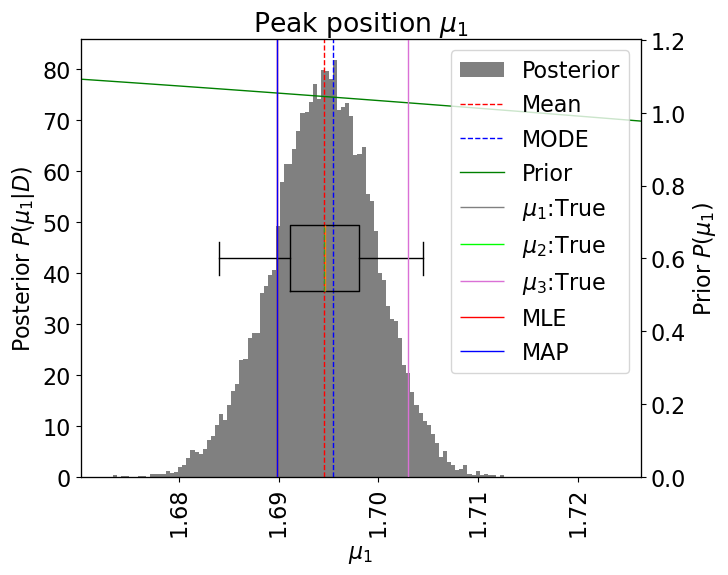

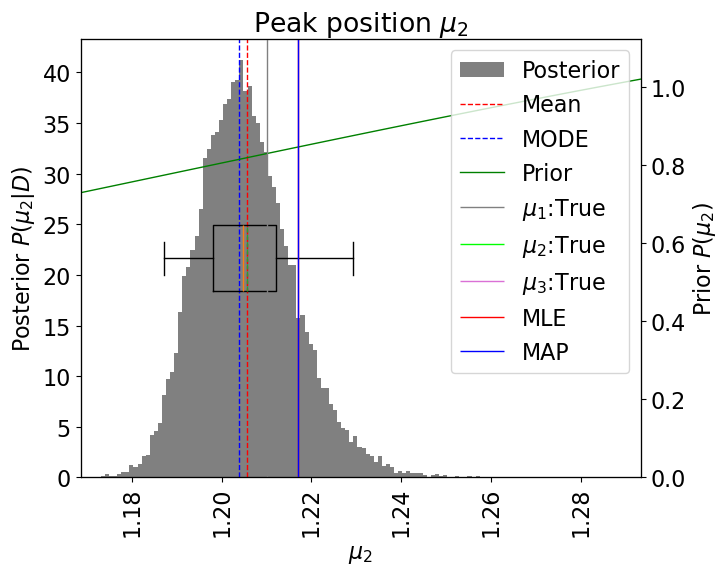

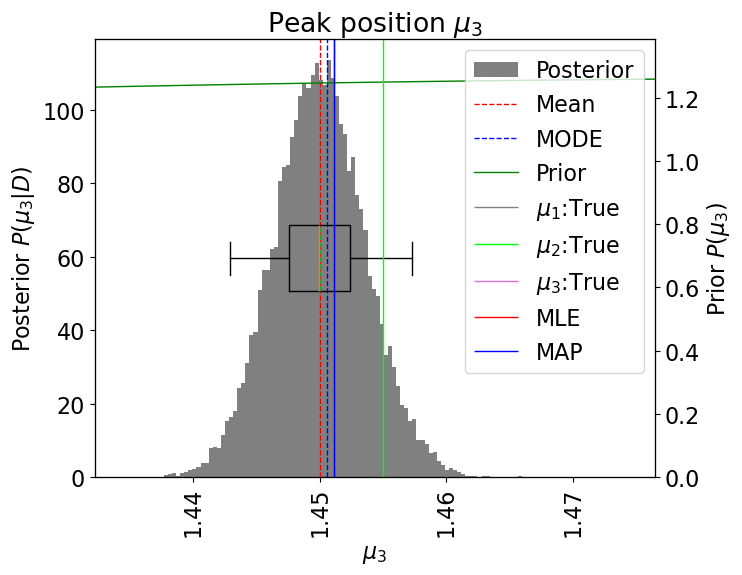

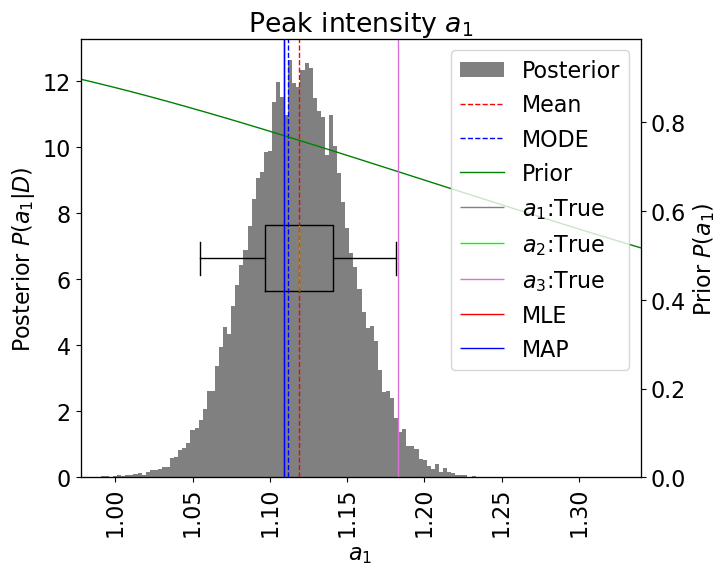

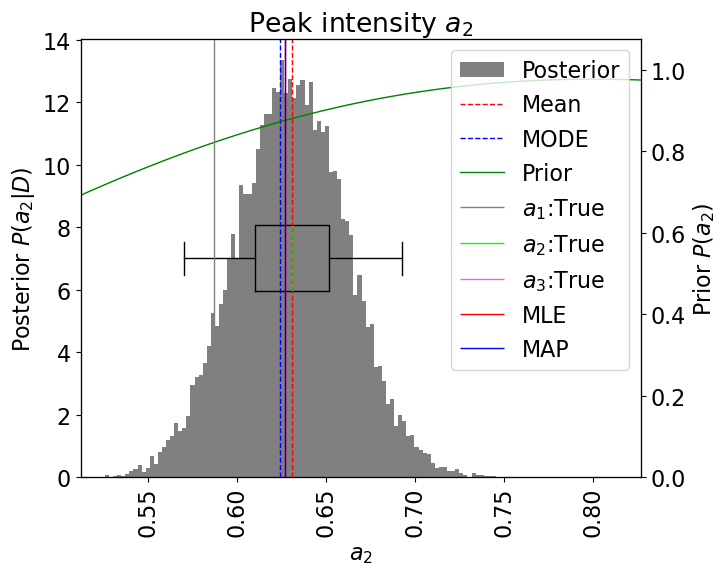

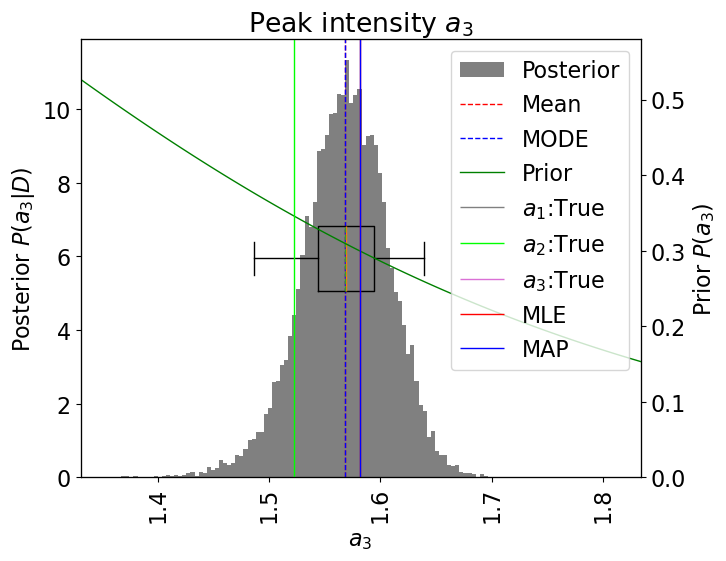

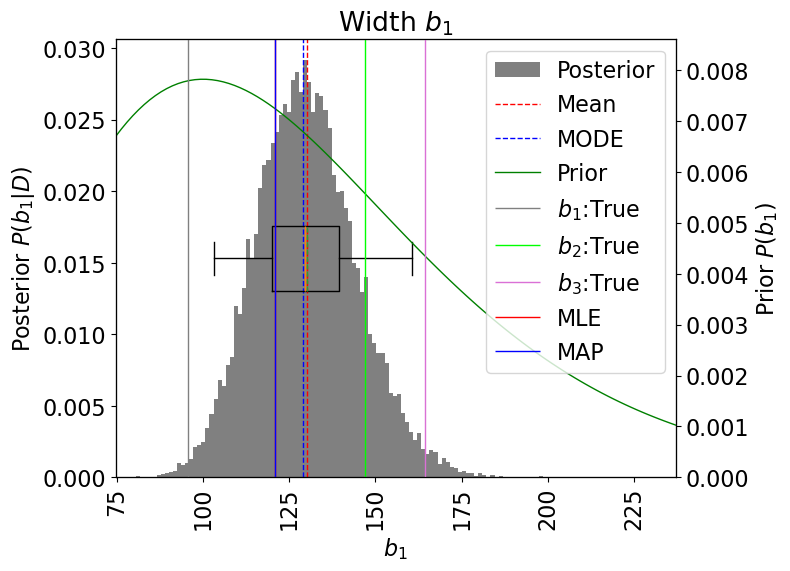

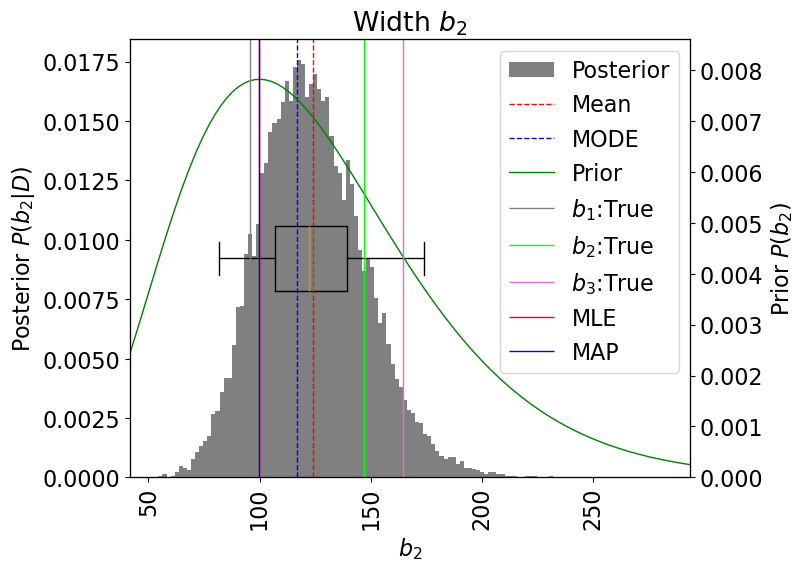

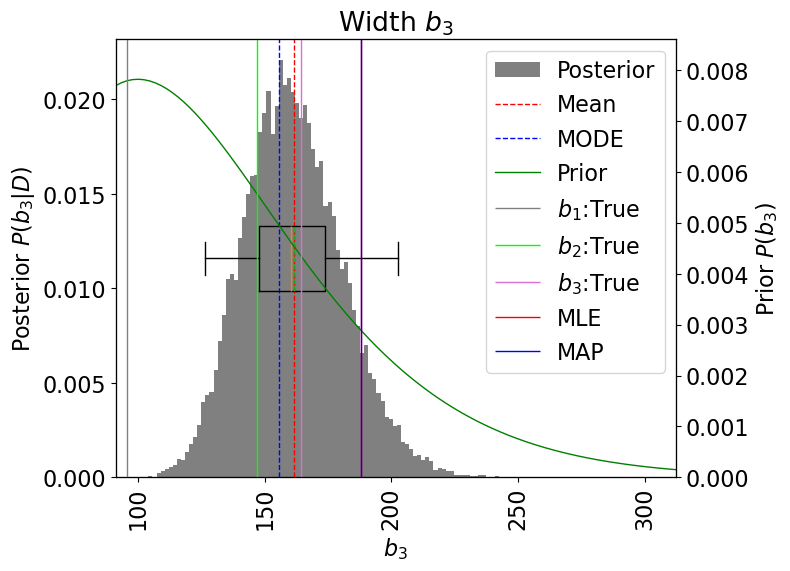

In [30]:
############################################
# 各事後確率分布等を出力
fig_base_fname = file_BaseName + 'Posterior'
#
for theta in thetas:
  #
  ###############
  key        = theta[0]
  key_label  = theta[1]
  title      = theta[2]
  prior_func = theta[3]
  prior_par1 = theta[4]
  prior_par2 = theta[5]
  #
  ###############
  pdfname = fig_base_fname + '-' + key + '.pdf'
  #
  ###############
  if key.startswith('mu'):
    Marks = [ [r'$\mu_{1}$:True', df_summary.at[ 'mu1', 'true'], 'gray',   'solid'],
              [r'$\mu_{2}$:True', df_summary.at[ 'mu2', 'true'], 'lime',   'solid'],
              [r'$\mu_{3}$:True', df_summary.at[ 'mu3', 'true'], 'orchid', 'solid'] ]
  elif key.startswith('a'):
    Marks = [ [r'$a_{1}$:True', df_summary.at[ 'a1', 'true'], 'gray',   'solid'],
              [r'$a_{2}$:True', df_summary.at[ 'a2', 'true'], 'lime',   'solid'],
              [r'$a_{3}$:True', df_summary.at[ 'a3', 'true'], 'orchid', 'solid'] ]
  elif key.startswith('b'):
    Marks = [ [r'$b_{1}$:True', df_summary.at[ 'b1', 'true'], 'gray',   'solid'],
              [r'$b_{2}$:True', df_summary.at[ 'b2', 'true'], 'lime',   'solid'],
              [r'$b_{3}$:True', df_summary.at[ 'b3', 'true'], 'orchid', 'solid'] ]
  #
  Marks.append( ['MLE',  df_summary.at[ key, 'MLE'],  'red',   'solid'] )
  Marks.append( ['MAP',  df_summary.at[ key, 'MAP'],  'blue',  'solid'] )
  #
  ###############
  fig, mean_, MODE_, bin_vals, bins = grf_PthetaD(
    df_trace[ key ], key_label,
    prior_func, prior_par1, prior_par2,
    theta_marks=Marks,title=title )
  #
  ###############
  fig.savefig( pdfname )

MAP値による再現データ

In [31]:
############################################
MAP_mu1 = df_summary.at[ 'mu1', 'MAP']
MAP_mu2 = df_summary.at[ 'mu2', 'MAP']
MAP_mu3 = df_summary.at[ 'mu3', 'MAP']
MAP_a1  = df_summary.at[ 'a1',  'MAP']
MAP_a2  = df_summary.at[ 'a2',  'MAP']
MAP_a3  = df_summary.at[ 'a3',  'MAP']
MAP_b1  = df_summary.at[ 'b1',  'MAP']
MAP_b2  = df_summary.at[ 'b2',  'MAP']
MAP_b3  = df_summary.at[ 'b3',  'MAP']
############################################
Y1_MAP = Gauss1(X, MAP_a1,MAP_mu1,MAP_b1 )
Y2_MAP = Gauss1(X, MAP_a2,MAP_mu2,MAP_b2 )
Y3_MAP = Gauss1(X, MAP_a3,MAP_mu3,MAP_b3 )
Y_MAP  = Gauss3(X, MAP_a1,MAP_mu1,MAP_b1, MAP_a2,MAP_mu2,MAP_b2, MAP_a3,MAP_mu3,MAP_b3 )

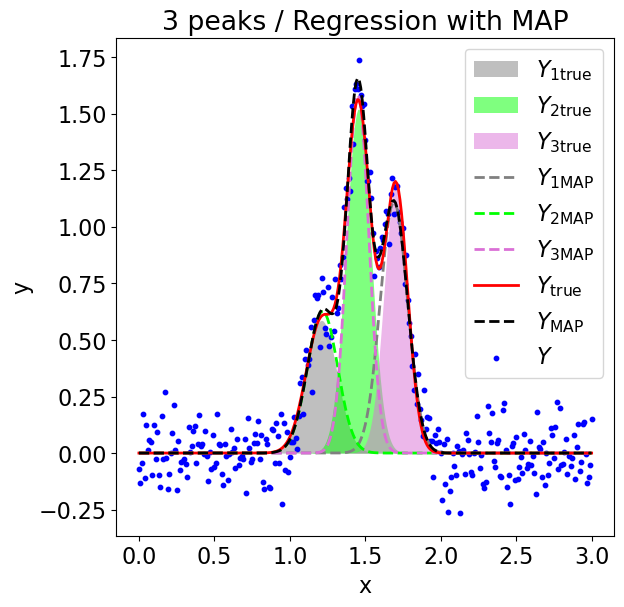

In [32]:
############################################
Ysets = [
    [ Y1_true, 4, r'$Y_{\rm 1true}$', 'gray'   ],
    [ Y2_true, 4, r'$Y_{\rm 2true}$', 'lime'   ],
    [ Y3_true, 4, r'$Y_{\rm 3true}$', 'orchid' ],
    [ Y1_MAP,  3, r'$Y_{\rm 1MAP}$',  'gray'   ],
    [ Y2_MAP,  3, r'$Y_{\rm 2MAP}$',  'lime'   ],
    [ Y3_MAP,  3, r'$Y_{\rm 3MAP}$',  'orchid' ],
    [ Y_true,  2, r'$Y_{\rm true}$',  'red'    ],
    [ Y_MAP,   3, r'$Y_{\rm MAP}$',   'black'  ],
    [ Y,       1, r'$Y$',             'blue'   ]
]
############################################
fig = grf_Gauss( X, Ysets, '3 peaks / Regression with MAP')
#
pdfName = FilePath + FileBaseName + "-reg.pdf"
fig.savefig( pdfName )
#print( pdfName )

In [33]:
df_trace.to_excel( FilePath + FileBaseName + '-trace.xlsx', sheet_name='NUTS' )